In [1]:
import copy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd
import pickle as pkl
import re
from scipy.stats import spearmanr, pearsonr, rankdata

from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.options.display.max_columns = 500
pd.options.mode.chained_assignment = None

from graph2net.parser import parse

In [2]:
run_stats=parse()

# Run Visualizations

## See all 512 Epoch Runs

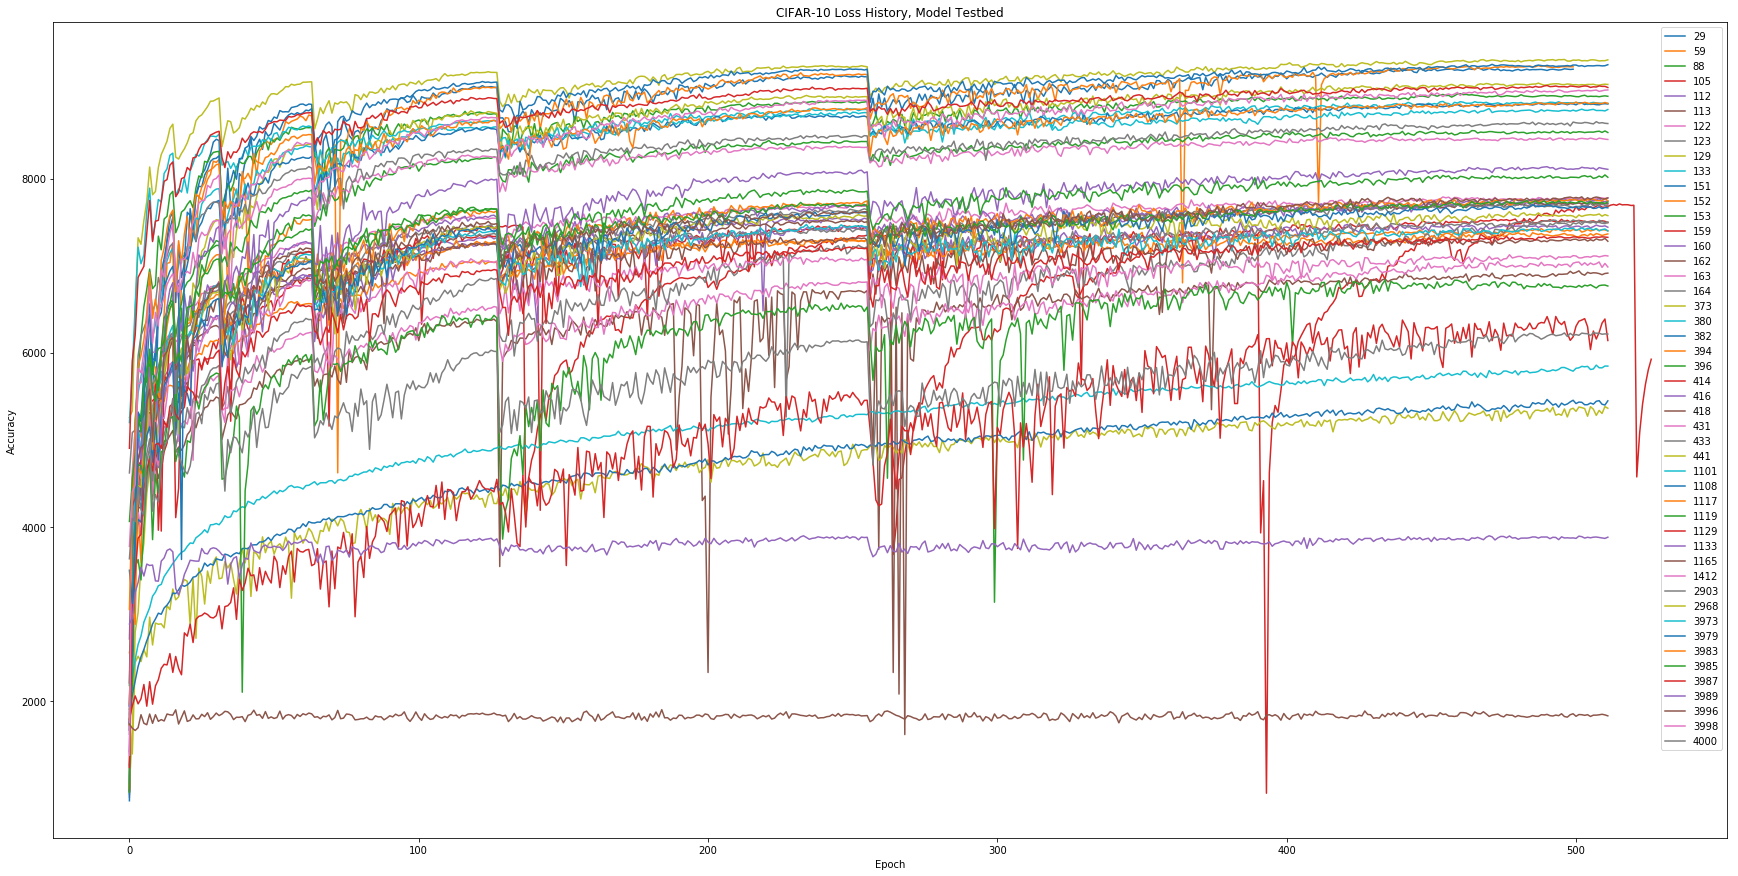

In [4]:
plt.figure(figsize=(30,15))
for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        plt.plot(curve,label=i)
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## See latest run compared to best 512 runs

0


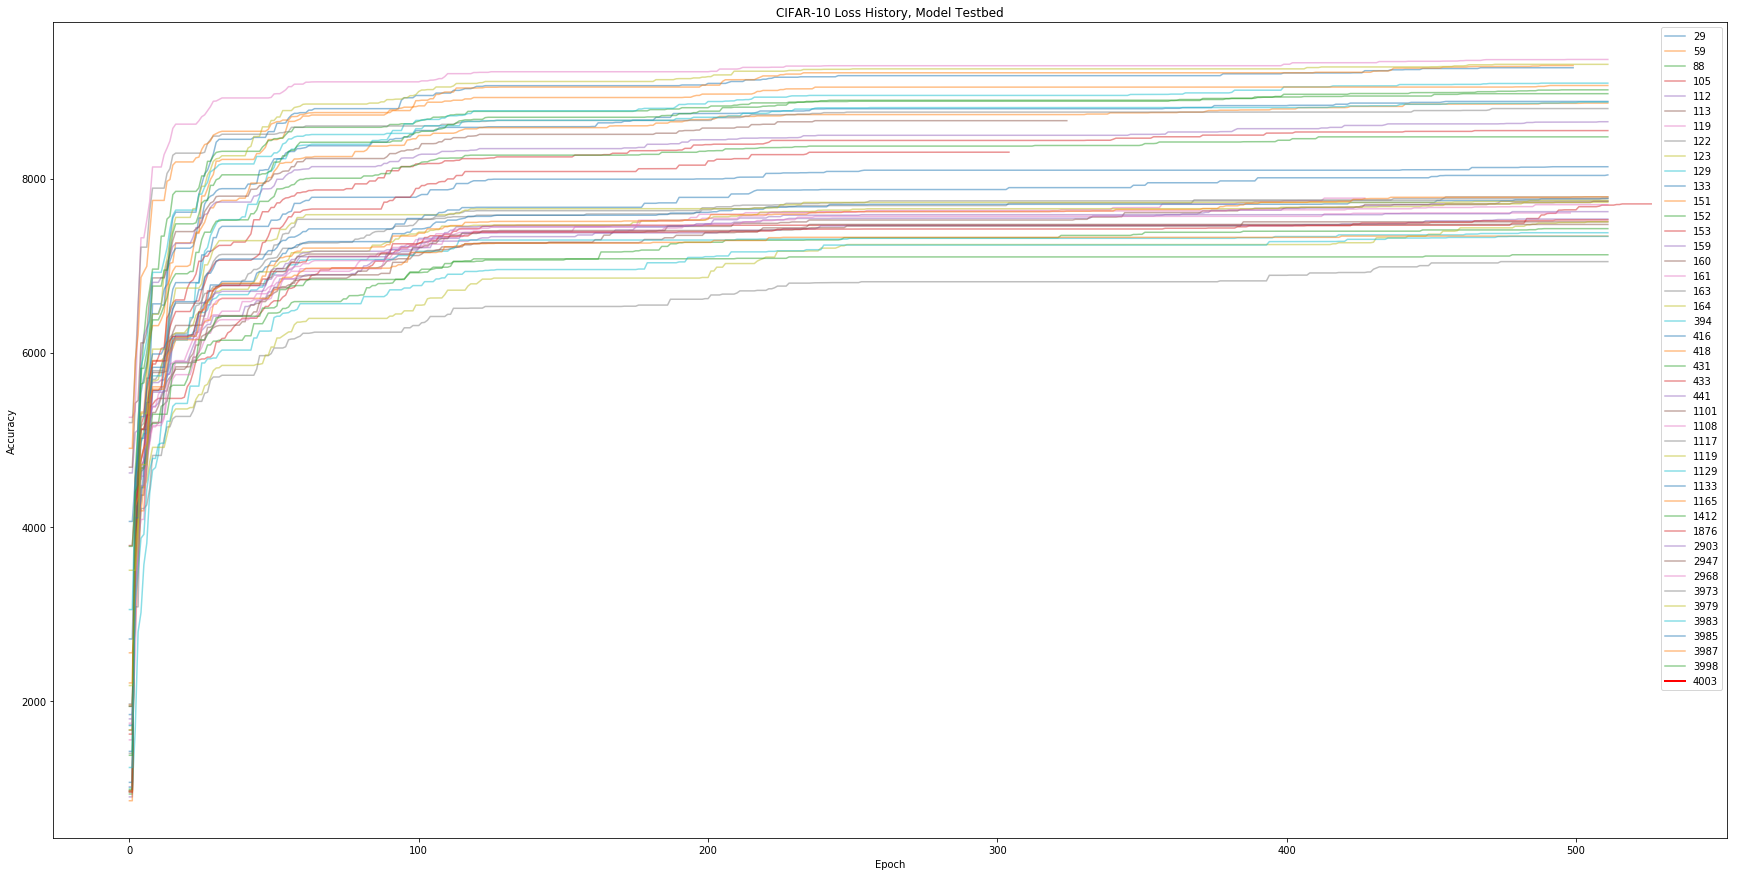

In [5]:
def cummax(arr):
    return [max(arr[:i]) if i>0 else arr[i] for i in range(len(arr))]

run_stats = run_stats.append(parse(last=True),sort=False)
plt.figure(figsize=(30,15))
best_runs = []
for i,curve in enumerate(run_stats['curve']):
    if 256<len(curve) and max(curve)>=7000:
        plt.plot(cummax(curve),label=i,alpha=.5)
        best_runs.append(curve)
    if i==len(run_stats)-1:
        print(len(curve))
        plt.plot(cummax(curve),label=i,linewidth=2,color='red')
        
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## See Change in Performance Rankings 

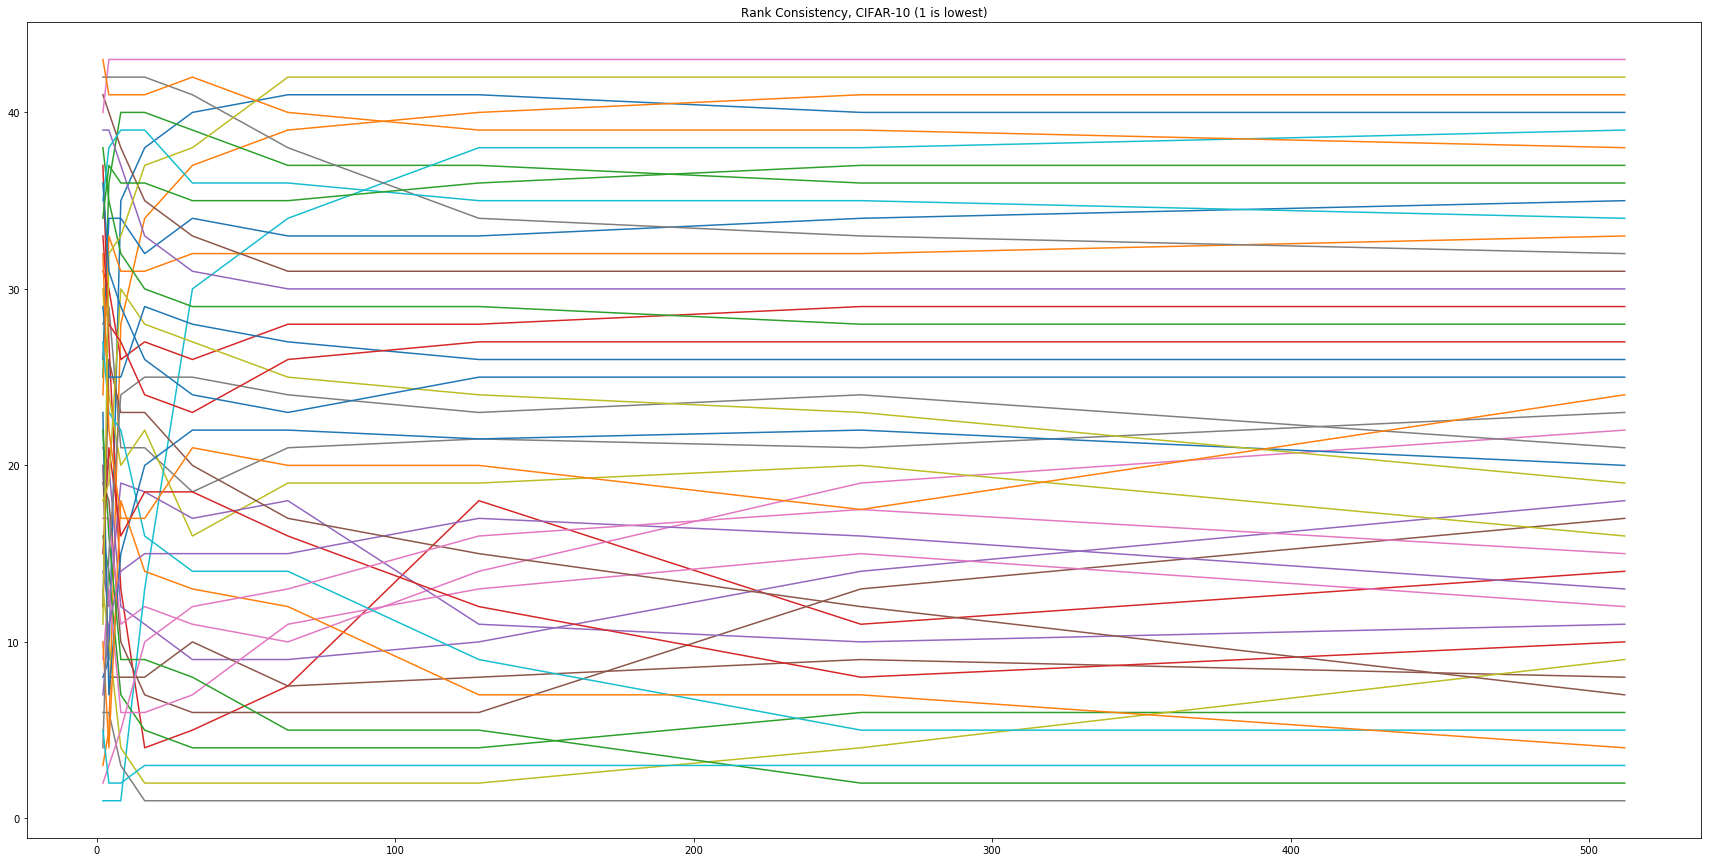

In [459]:
import scipy.stats as ss
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(30,15))
ranks = []
for restart in [2**x for x in range(1,10)]:
    best = [max(best_run[:restart]) for best_run in best_runs]
    ranks.append(ss.rankdata(best))
    
plt.plot([2**x for x in range(1,10)],ranks)
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.title("Rank Consistency, CIFAR-10 (1 is lowest)")
plt.show()

# Macro Train Predictors

In [3]:
predictor_df = parse()

def macro_process(predictor_df):
    losses = predictor_df[predictor_df['epoch']>=500]
    if predictor_df['epoch'].iloc[-1]>=50:
        losses.append(predictor_df.iloc[-1])
    losses['curve']=losses['curve'].apply(lambda x: x+[max(x)]*12 if len(x)==500 else x)
    losses['curve']=losses['curve'].apply(lambda x: x[:512] if len(x)>512 else x)
    losses['matrix']=losses['cell_matrices'].apply(lambda x: x[0] if len(x)<3 else np.array(x))
    losses['reductions']=losses['cell_types'].apply(sum)
    losses['parallel']=losses['cell_matrices'].apply(lambda x: len(x) if len(x)<3 else 1)
    losses['cells']=losses['cell_types'].apply(len)
    losses['nodes']=losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))
    losses['cell']=losses['cell_matrices'].apply(lambda x: np.array(x[0]) if len(x)<3 else np.array(x))
    losses['lr_max']=losses['lr_schedule'].apply(lambda x: x['lr_max'])
    losses['fill']=losses['cell'].apply(lambda x: len(np.triu(x).nonzero()[0])/x.size)

    losses = losses[losses['reductions']>4]
    for i in range(512):
        if i==0:
            losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x:x[0])
        else:
            losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x: max(x[:i+1]))
    return losses

losses = macro_process(predictor_df)
losses.to_pickle('pickle_jar/macro_losses.pkl')
losses.iloc[:-1]

auxiliaries auxillaries  \
29           NaN         NaN   
59           NaN         NaN   
122          NaN         NaN   
123          NaN         NaN   
129          NaN         NaN   
133          NaN         NaN   
151          NaN         NaN   
152          NaN         NaN   
153          NaN         NaN   
159          NaN         NaN   
160          NaN         NaN   
162          NaN         NaN   
163          NaN         NaN   
164          NaN         NaN   
373          NaN         NaN   
380          NaN         NaN   
382          NaN         NaN   
394          NaN         NaN   
396          NaN         NaN   
414          NaN         NaN   
416          NaN         NaN   
418          NaN         NaN   
431          NaN         NaN   
433          NaN         NaN   
441          NaN         NaN   
1101         NaN         NaN   
1108         NaN         NaN   
1117         NaN         NaN   
1119         NaN         NaN   
1129         NaN         NaN   
1133         NaN         NaN   
1165         NaN         NaN   
1412         NaN         NaN   
2903         NaN         NaN   
2968         [2]         NaN   
3973         [2]         NaN   
3979         [2]         NaN   
3983         NaN         [2]   
3985         NaN         [2]   
3987         NaN         [2]   
3989         NaN         [2]   
3996         NaN         [2]   
3998         NaN         [2]   
4000         NaN         [2]   
4377         NaN         [2]   

                                          cell_matrices  \
29    [[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...   
59    [[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...   
122   [[[0.0, 11.0, 11.0, 5.0, 11.0], [0.0, 0.0, 0.0...   
123   [[[0.0, 11.0, 11.0, 5.0, 11.0], [0.0, 0.0, 0.0...   
129   [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
133   [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
151   [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
152   [[[0.0, 11.0, 11.0, 5.0, 11.0], [0.0, 0.0, 0.0...   
153   [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
159   [[[1, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0,...   
160   [[[0.0, 11.0, 11.0, 5.0, 11.0], [0.0, 0.0, 0.0...   
162   [[[0, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0,...   
163   [[[0, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0,...   
164   [[[0, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0,...   
373   [[[0.0, 1.0, 10.0, 0.0], [1.0, 0.0, 0.0, 1.0],...   
380   [[[0.0, 1.0, 14.0, 0.0, 0.0, 0.0], [0.0, 0.0, ...   
382   [[[0.0, 9.0, 5.0, 0.0], [0.0, 0.0, 14.0, 1.0],...   
394   [[[0.0, 1.0, 1.0, 0.0, 1.0, 12.0], [1.0, 0.0, ...   
396   [[[0.0, 6.0, 12.0, 0.0], [1.0, 0.0, 6.0, 9.0],...   
414   [[[0.0, 1.0, 0.0, 1.0, 5.0, 0.0, 10.0], [1.0, ...   
416   [[[0.0, 12.0, 13.0], [1.0, 0.0, 1.0], [1.0, 0....   
418   [[[0.0, 1.0, 6.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1...   
431   [[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...   
433   [[[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 12.0],...   
441   [[[0.0, 4.0, 1.0, 14.0, 15.0], [1.0, 0.0, 0.0,...   
1101  [[[0.0, 5.0, 1.0, 11.0, 0.0, 0.0, 10.0], [1.0,...   
1108  [[[0.0, 1.0, 1.0, 15.0, 0.0, 8.0, 0.0], [1.0, ...   
1117  [[[0.0, 1.0, 15.0], [1.0, 0.0, 1.0], [1.0, 0.0...   
1119  [[[0.0, 1.0, 10.0, 0.0], [0.0, 0.0, 0.0, 4.0],...   
1129  [[[0.0, 1.0, 5.0], [1.0, 0.0, 1.0], [1.0, 0.0,...   
1133  [[[0.0, 9.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...   
1165  [[[0.0, 12.0, 1.0, 1.0, 0.0, 0.0, 0.0, 9.0], [...   
1412  [[[0.0, 1.0, 0.0, 15.0, 0.0, 1.0, 12.0], [0.0,...   
2903  [[[0.0, 1.0, 8.0, 1.0, 0.0, 0.0, 13.0, 15.0, 5...   
2968  [[[0, 3, 0, 1], [0, 0, 13, 0], [0, 0, 0, 2], [...   
3973  [[[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 8.0, 0.0], ...   
3979  [[[0, 3, 0, 1], [0, 0, 13, 0], [0, 0, 0, 2], [...   
3983  [[[0.0, 15.0, 1.0, 0.0, 12.0, 0.0, 4.0], [1.0,...   
3985  [[[0.0, 1.0, 7.0, 4.0, 2.0], [1.0, 0.0, 1.0, 0...   
3987  [[[0.0, 1.0, 1.0, 13.0, 1.0], [1.0, 0.0, 8.0, ...   
3989  [[[0.0, 10.0, 1.0], [1.0, 0.0, 8.0], [1.0, 0.0...   
3996  [[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0,..

## Max by Epoch

In [4]:
all_macro_funcs = []
all_macro_metrics = []

for addition in [[]]:
    for test_run in range(50):
        train,test = train_test_split(losses[:-1],test_size=.25)
        print(test_run,end="\r")
        epoch_metrics = []
        funcs = {}
        for i in range(512):
            regr = linear_model.LinearRegression()

            column_selector=['max_curve_{}'.format(i),'params','parallel','cells','nodes','scale','lr_max']+addition
            train_X = train[column_selector]
            train_Y = train['max']

            test_X = test[column_selector]
            test_Y = test['max']

            regr = linear_model.LinearRegression()
            regr.fit(train_X,train_Y)
            x_func = regr.intercept_+np.dot(train_X,regr.coef_)
            pred = regr.intercept_+np.dot(test_X,regr.coef_)
            c95 = np.std(test_Y.values-pred)*1.96
            funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':column_selector}

            metrics = {}
            metrics["Pearsonr"]=pearsonr(pred,test_Y)[0]
            metrics['c95']=int(c95)
            epoch_metrics.append(metrics)

            if addition and test_run==49 and not i%50:
                print("\n\n\n=={}==============================".format(i))
                xy_df = pd.DataFrame(test_X*regr.coef_)
                xy_df['intercept']=regr.intercept_
                xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
                xy_df['_score']=test_Y
                xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
                display(xy_df)
                #display(test)

                plt.subplot(121)
                plt.plot(pred,test_Y,".")
                plt.plot(pred,pred)
                plt.plot(pred,pred+c95,alpha=.5)
                plt.plot(pred,pred-c95,alpha=.5)
                plt.title("Test")

                plt.subplot(122)
                plt.plot(x_func,train_Y,".")
                plt.plot(x_func,x_func)
                plt.plot(x_func,x_func+c95,alpha=.5)
                plt.plot(x_func,x_func-c95,alpha=.5)
                plt.title("Train")
                plt.tight_layout()

                plt.show()
                print('\tIntercept:', regr.intercept_)
                print('\tCoefficients: \n\t', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
                print("\tPearsonR: {:.3f},{:.3f}".format(*pearsonr(x_func,train_Y)))
                print("\t95%: ±{:.2f}".format(c95))
        all_macro_metrics.append(epoch_metrics)
        all_macro_funcs.append(funcs)

    summaries = [[] for _ in range(512)]
    for epoch_metrics in all_macro_metrics:
        for i,epoch_metric in enumerate(epoch_metrics):
            summaries[i].append(epoch_metric)
    summary_dfs = [pd.DataFrame(x) for x in summaries]

    epoch_means = pd.DataFrame([summary_df.mean() for summary_df in summary_dfs])
    print(column_selector)
    display(epoch_means.loc[[2**x for x in range(0,9)]+[511]])

['max_curve_511', 'params', 'parallel', 'cells', 'nodes', 'scale', 'lr_max']


Pearsonr      c95
1    0.573861  2526.84
2    0.680463  2238.84
4    0.725052  2135.30
8    0.807749  1777.90
16   0.869473  1478.42
32   0.912140  1217.20
64   0.939852  1001.56
128  0.965693   748.26
256  0.991326   382.14
511  1.000000     0.00

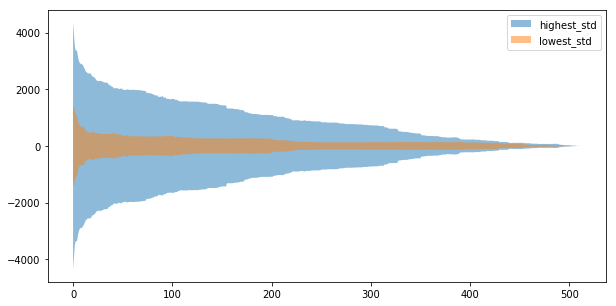

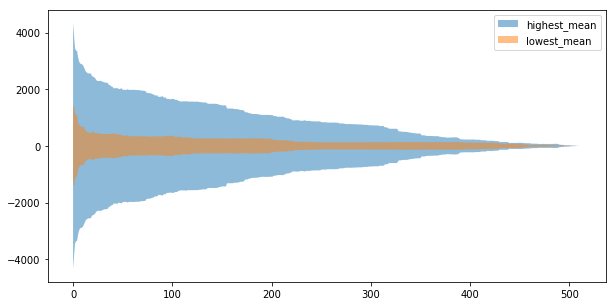

50


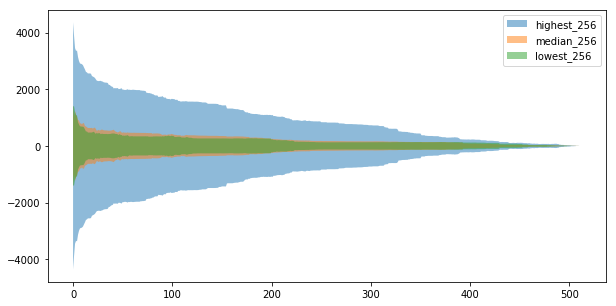

['max_curve_0', 'params', 'parallel', 'cells', 'nodes', 'scale', 'lr_max']


In [5]:
plt.figure(figsize=(10,5))
all_macro_funcs.sort(key=lambda x: np.std([x[i]['95'] for i in range(512)]))
maxes,mins = np.array([all_macro_funcs[-1][i]['95'] for i in range(512)]),np.array([all_macro_funcs[0][i]['95'] for i in range(512)])
plt.fill_between(range(512),-maxes,maxes,label="highest_std",alpha=.5)
plt.fill_between(range(512),-mins,mins,label="lowest_std",alpha=.5)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
all_macro_funcs.sort(key=lambda x: np.mean([x[i]['95'] for i in range(512)]))
maxes,mins = np.array([all_macro_funcs[-1][i]['95'] for i in range(512)]),np.array([all_macro_funcs[0][i]['95'] for i in range(512)])
plt.fill_between(range(512),-maxes,maxes,label="highest_mean",alpha=.5)
plt.fill_between(range(512),-mins,mins,label="lowest_mean",alpha=.5)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
n = len(all_macro_funcs)
print(n)
all_macro_funcs.sort(key=lambda x: x[256]['95'])
maxes,mins = np.array([all_macro_funcs[-1][i]['95'] for i in range(512)]),np.array([all_macro_funcs[0][i]['95'] for i in range(512)])
median = np.array([all_macro_funcs[n//50][i]['95'] for i in range(512)])
plt.fill_between(range(512),-maxes,maxes,label="highest_256",alpha=.5)
plt.fill_between(range(512),-median,median,label="median_256",alpha=.5)
plt.fill_between(range(512),-mins,mins,label="lowest_256",alpha=.5)
plt.legend()
plt.show()

print(all_macro_funcs[0][0]['coef_names'])
pkl.dump(all_macro_funcs[0],open('macro_loss_predictors.pkl',"wb"))

## Check Macro Predictions

Actual Max: 9312


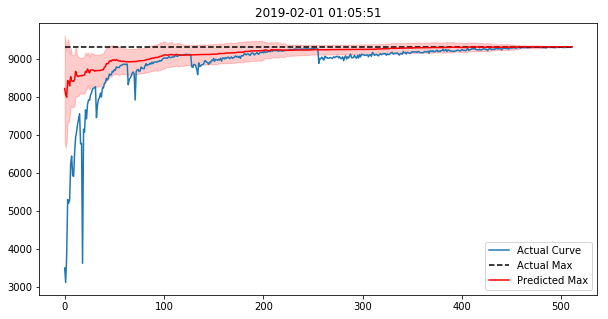

Actual Max: 8879


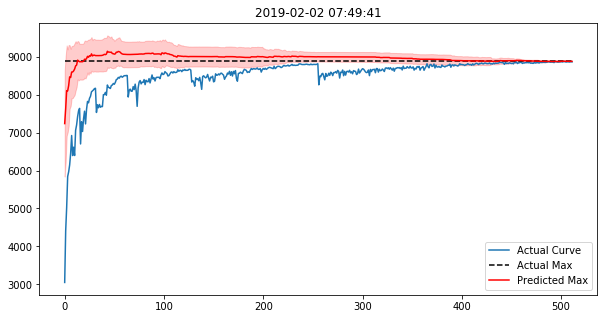

Actual Max: 8042


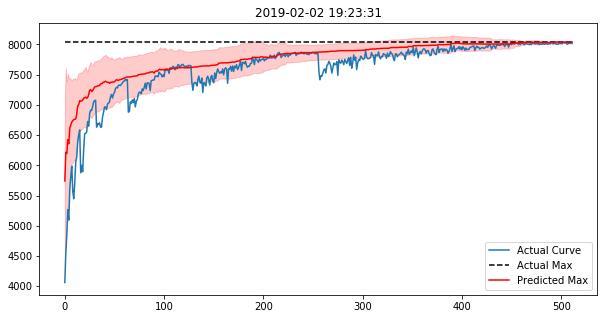

Actual Max: 9069


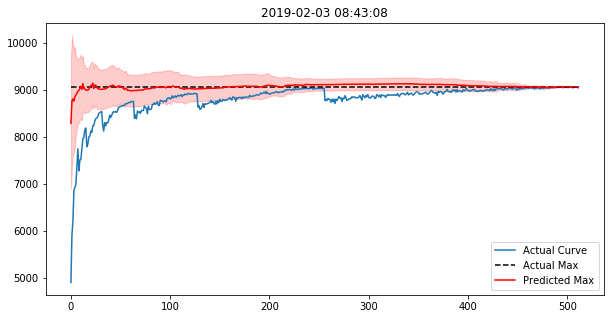

Actual Max: 3897


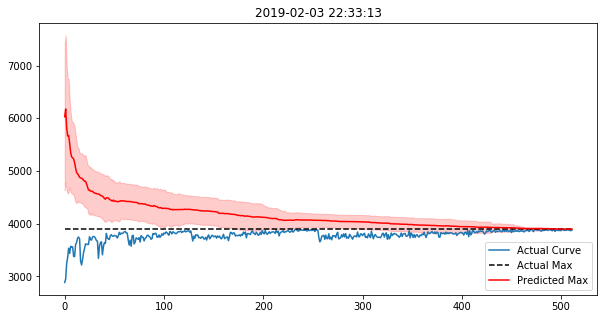

Actual Max: 1900


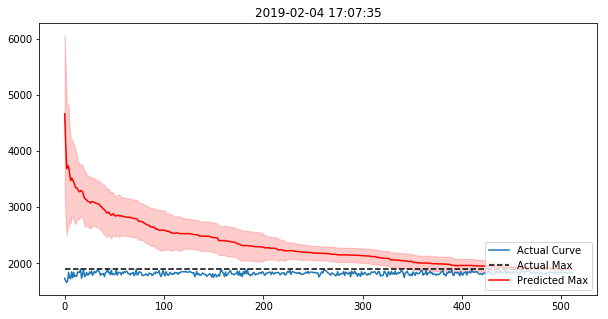

Actual Max: 9019


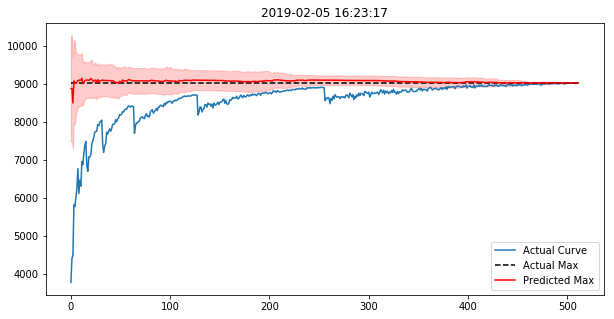

Actual Max: 6229


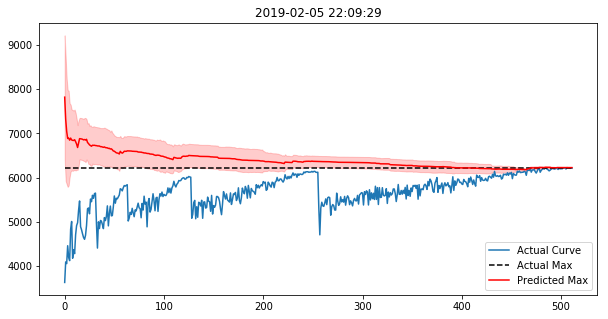

Actual Max: 9311


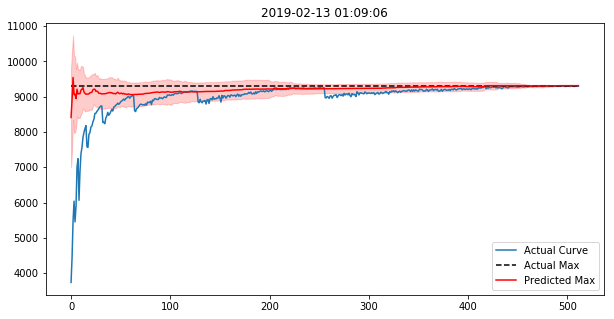

Actual Max: 9427


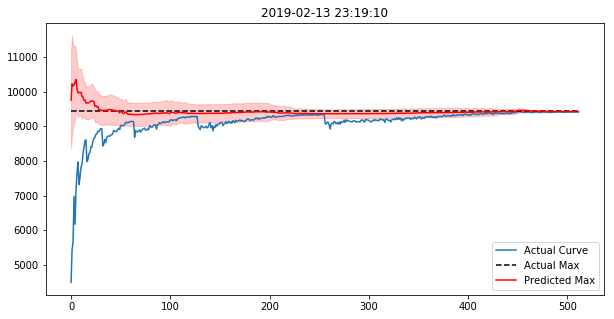

In [7]:
funcs = pkl.load(open('macro_loss_predictors.pkl',"rb"))

losses= macro_process(predictor_df.append(parse(last=True),sort=False))

for idx,row in list(losses.iloc[-10:].iterrows()):
    curve_len = len(row['curve'])
    plt.figure(figsize=(10,5))
    plt.plot(row['curve'],label='Actual Curve')
    preds = []
    for i in range(curve_len):
        X = row[['max_curve_{}'.format(i),'params','parallel','cells','nodes','scale','lr_max']]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    c95s = np.array([value['95'] for (key,value) in list(funcs.items())[:curve_len]])
    print("Actual Max:",max(row['curve']))
    if curve_len==512:
        plt.plot([max(row['curve'])]*curve_len,label="Actual Max",color='black',linestyle='dashed')
    else:
        plt.fill_between(range(curve_len),(preds+c95s)[-1],(preds-c95s)[-1],color='blue',alpha=.1,label="Latest Bounds")
    
    plt.fill_between(range(curve_len),preds+c95s,preds-c95s,color='red',alpha=.2)

        
    plt.plot(preds,label="Predicted Max",color='red')
    
    
    plt.title(row['run_date'])
    plt.legend(loc='lower right')
    plt.show()

# Micro Train Predictors

In [15]:
micro_losses               = copy.copy(run_stats)
micro_losses               = micro_losses[micro_losses['cell_types'].apply(lambda x: x==[1,1])]
micro_losses               = micro_losses[micro_losses['curve'].apply(lambda x: len(x)>=8)]
micro_losses['cell_matrices']   = micro_losses['cell_matrices'].apply(lambda x: x if len(x)<3 else [x])
micro_losses['reductions'] = micro_losses['cell_types'].apply(sum)
micro_losses['curve']      = micro_losses['curve'].apply(lambda x: x[:8] if len(x)>8 else x)
micro_losses['parallel']   = micro_losses['cell_matrices'].apply(len)
micro_losses['cells']      = micro_losses['cell_types'].apply(len)
micro_losses['nodes']      = micro_losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))

for i in range(8):
    if i==0:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x:x[0])
        micro_losses['max_increase_{}'.format(i)]=micro_losses['curve'].apply(lambda x: 1)
    else:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x: max(x[:i+1]))
        micro_losses['max_increase_{}'.format(i)]=micro_losses['max_curve_{}'.format(i)]-micro_losses['max_curve_{}'.format(0)]
        
micro_losses.to_pickle('pickle_jar/micro_losses.pkl')
micro_losses.iloc[0:10]

auxiliaries auxillaries                                      cell_matrices  \
52         NaN         NaN  [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
57         NaN         NaN  [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
64         NaN         NaN  [[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...   
82         NaN         NaN  [[[0.0, 8.0, 0.0, 6.0, 4.0], [0.0, 0.0, 13.0, ...   
92         NaN         NaN  [[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...   
93         NaN         NaN  [[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...   
94         NaN         NaN  [[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...   
95         NaN         NaN  [[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...   
96         NaN         NaN  [[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...   
97         NaN         NaN  [[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...   

   cell_types                                             curve data  \
52     [1, 1]  [4482, 5538, 4659, 5930, 6327, 6035, 6970, 7195]  NaN   
57     [1, 1]  [4888, 5242, 6200, 6538, 6707, 7089, 6278, 7460]  NaN   
64     [1, 1]  [4629, 5455, 5651, 5207, 5188, 4589, 5942, 6620]  NaN   
82     [1, 1]  [4707, 4309, 5021, 5670, 5688, 6307, 6582, 6779]  NaN   
92     [1, 1]   [936, 4499, 4847, 4875, 5102, 5225, 5356, 5367]  NaN   
93     [1, 1]   [721, 4513, 4872, 5036, 5217, 5354, 5447, 5418]  NaN   
94     [1, 1]  [1063, 4403, 4942, 5101, 5321, 5409, 5421, 5560]  NaN   
95     [1, 1]   [915, 4525, 4886, 5110, 5207, 5236, 5392, 5344]  NaN   
96     [1, 1]   [923, 4321, 4768, 5034, 5108, 5244, 5402, 5479]  NaN   
97     [1, 1]   [909, 4508, 4865, 4978, 5158, 5266, 5337, 5392]  NaN   

   drop_path  early_terminate  epoch  epochs   log    lr  \
52       NaN            False     10   500.0  True  0.01   
57      True            False     10    10.0  True  0.01   
64      True            False     10    10.0  True  0.01   
82      True            False     10    10.0  True  0.01   
92      True            False     10    10.0  True   NaN   
93      True             True      9    10.0  True   NaN   
94      True            False     10    10.0  True   NaN   
95      True            False     10    10.0  True   NaN   
96      True            False     10    10.0  True   NaN   
97      True            False     10    10.0  True   NaN   

                                          lr_schedule   max  momentum  \
52  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...  7195       0.9   
57  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...  7460       0.9   
64  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...  6620       0.9   
82  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...  7075       0.9   
92  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...  5434       0.9   
93  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...  5481       0.9   
94  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...  5587       0.9   
95  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...  5459       0.9   
96  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...  5556       0.9   
97  {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...  5465       0.9   

     params per_epoch_time predictions prefix residual_cells  \
52  61108.0           None          []    NaN            NaN   
57  61108.0           None          []    NaN            NaN   
64  68020.0           None          []    NaN            NaN   
82  44926.0           None          []    NaN            NaN   
92  22282.0           None          []    NaN            NaN   
93  22282.0           None          []    NaN            NaN   
94  22282.0           None          []    NaN            NaN   
95  22282.0           None          []    NaN            NaN   
96  22282.0           None          []    NaN            NaN   
97  22282.0           None          []    NaN            NaN   

               run_date  scale                    scales      time_taken  \
52  2018-10-31 14:18:34    2.0                (2.0, 0.5)            None

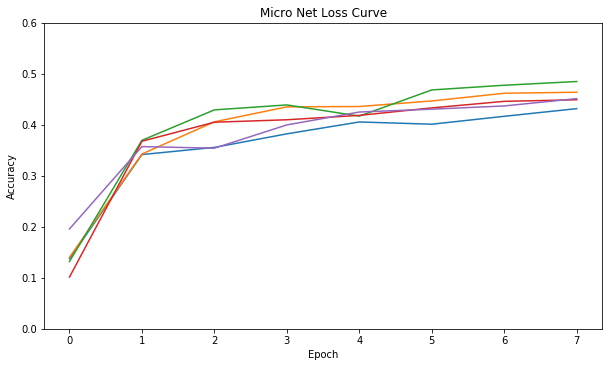

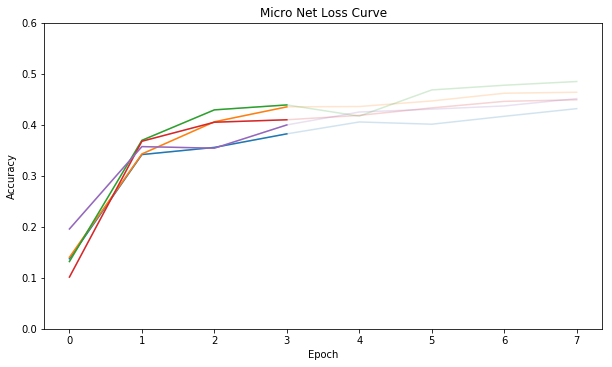

In [519]:

micro_sample = micro_losses.sample(5)['curve']

plt.figure(figsize=(10,5.63))
for i,curve in enumerate(micro_sample):
    plt.plot([x/10000 for x in curve],color=cm.tab10(i))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,.6)
plt.title("Micro Net Loss Curve")
plt.savefig("red_hat_figures/micro_solo.png".format(i),dpi=250)
plt.show()

plt.figure(figsize=(10,5.63))
for i,curve in enumerate(micro_sample):
    plt.plot([x/10000 for x in curve],alpha=.2,color=cm.tab10(i))
    plt.plot([x/10000 for x in curve[:4]],color=cm.tab10(i))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,.6)
plt.title("Micro Net Loss Curve")
plt.savefig("red_hat_figures/micro_split_solo.png".format(i),dpi=250)
plt.show()

['max_curve_0', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 0==============================
Train/test sizes: 650, 100


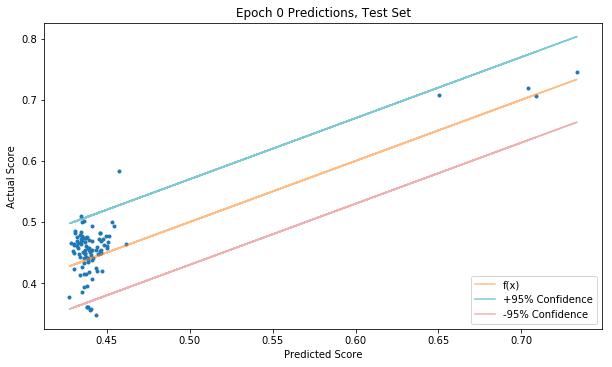

Intercept: 5190.113648856925
700.5491201723364
Coefficients: 
 max_curve_0: 0.0320 params: 0.0528 reductions: 0.0000 parallel: -1070.8222 cells: 0.0000 nodes: -28.1534
['max_curve_0', 'max_curve_1', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 1==============================
Train/test sizes: 650, 100


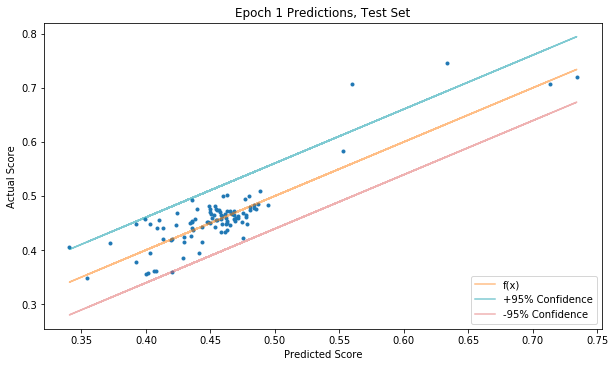

Intercept: 883.6471980993947
605.715822637548
Coefficients: 
 max_curve_0: -0.1128 max_curve_1: 0.9551 params: 0.0121 reductions: 0.0000 parallel: -28.7346 cells: 0.0000 nodes: 46.6765
['max_curve_0', 'max_curve_1', 'max_curve_2', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 2==============================
Train/test sizes: 650, 100


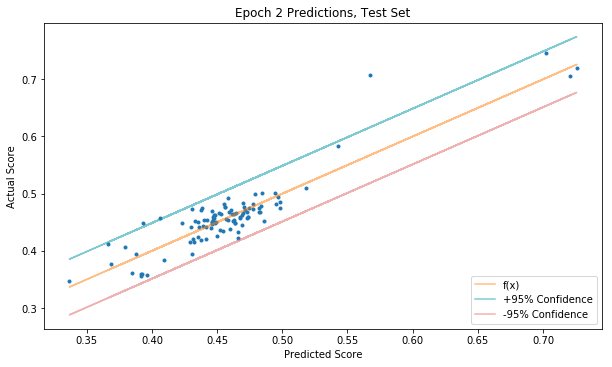

Intercept: 274.6578479715945
487.26432280549255
Coefficients: 
 max_curve_0: -0.0748 max_curve_1: 0.0177 max_curve_2: 1.0086 params: 0.0080 reductions: -0.0000 parallel: 75.8868 cells: 0.0000 nodes: 33.6292
['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 3==============================
Train/test sizes: 650, 100


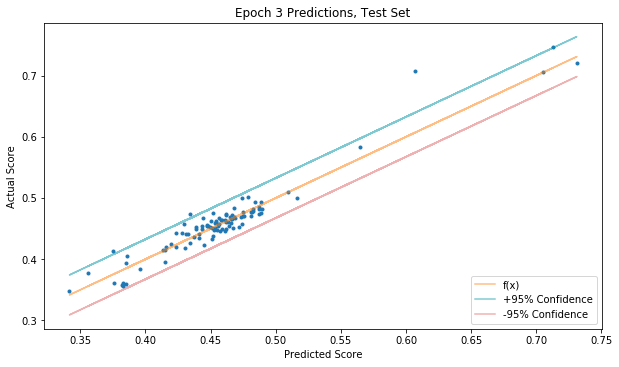

Intercept: -231.4729921872995
326.2510487777
Coefficients: 
 max_curve_0: -0.0525 max_curve_1: -0.1192 max_curve_2: 0.1648 max_curve_3: 0.9844 params: 0.0042 reductions: 0.0000 parallel: 437.2707 cells: 0.0000 nodes: 14.6870
['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 4==============================
Train/test sizes: 650, 100


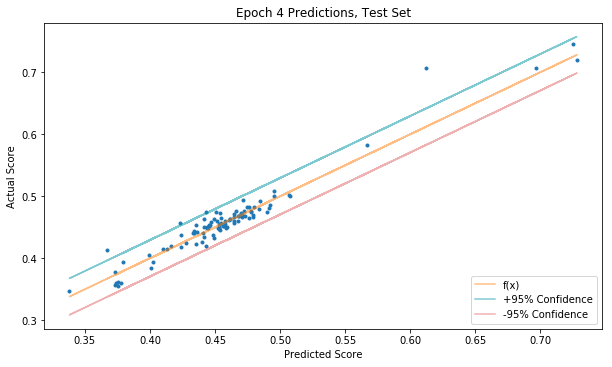

Intercept: -450.53606005506117
294.3716666352382
Coefficients: 
 max_curve_0: -0.0103 max_curve_1: -0.1246 max_curve_2: 0.0338 max_curve_3: 0.2048 max_curve_4: 0.9084 params: 0.0030 reductions: -0.0000 parallel: 530.5286 cells: 0.0000 nodes: 8.7854
['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'max_curve_5', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 5==============================
Train/test sizes: 650, 100


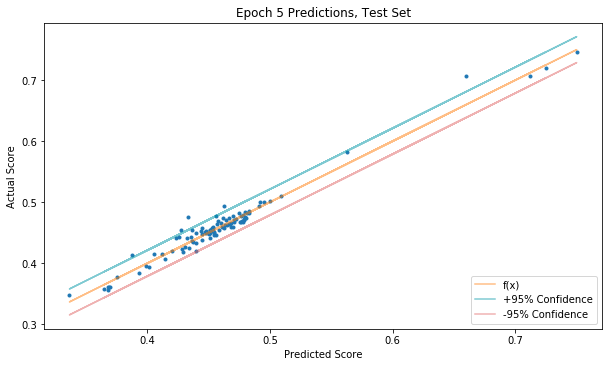

Intercept: -635.7112089816474
212.52531840566886
Coefficients: 
 max_curve_0: 0.0085 max_curve_1: -0.0874 max_curve_2: -0.0377 max_curve_3: 0.0995 max_curve_4: 0.1807 max_curve_5: 0.8634 params: 0.0024 reductions: 0.0000 parallel: 624.2941 cells: 0.0000 nodes: 4.8193
['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'max_curve_5', 'max_curve_6', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 6==============================
Train/test sizes: 650, 100


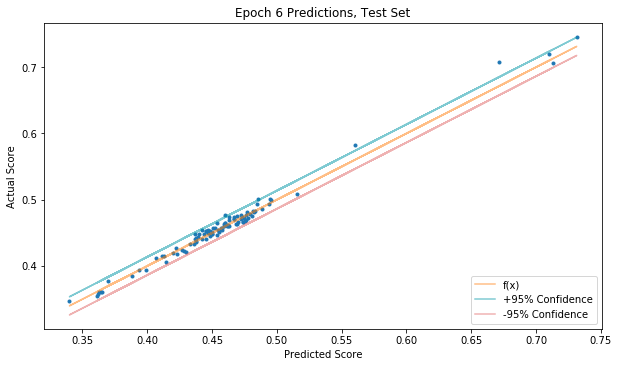

Intercept: -595.3678500874476
136.68131280727175
Coefficients: 
 max_curve_0: 0.0059 max_curve_1: -0.0375 max_curve_2: -0.0253 max_curve_3: 0.0310 max_curve_4: 0.0521 max_curve_5: 0.1733 max_curve_6: 0.8194 params: 0.0010 reductions: -0.0000 parallel: 567.1599 cells: 0.0000 nodes: 2.8215
['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'max_curve_5', 'max_curve_6', 'max_curve_7', 'params', 'reductions', 'parallel', 'cells', 'nodes']



==Epoch 7==============================
Train/test sizes: 650, 100


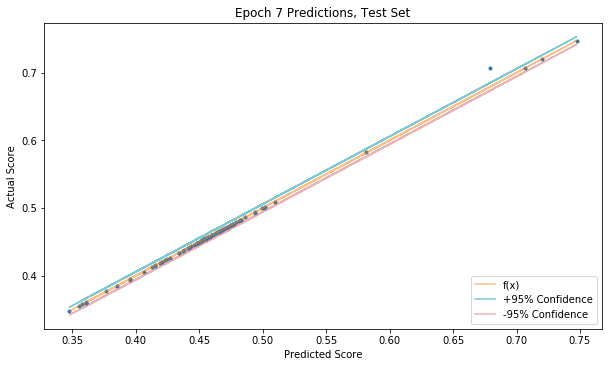

Intercept: 18.135694411745135
56.920420593221024
Coefficients: 
 max_curve_0: -0.0063 max_curve_1: -0.0029 max_curve_2: 0.0009 max_curve_3: 0.0078 max_curve_4: -0.0098 max_curve_5: 0.0055 max_curve_6: 0.0131 max_curve_7: 0.9866 params: 0.0006 reductions: -0.0000 parallel: -10.8147 cells: 0.0000 nodes: -1.0193
['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'max_curve_5', 'max_curve_6', 'max_curve_7', 'params', 'reductions', 'parallel', 'cells', 'nodes']


95% Confidence  Actual Bottom-50 in Preds  Actual Top-10 in Preds  \
0     1043.380304                       8.59                    7.41   
1      602.324390                       1.98                    8.52   
2      440.570070                       0.59                    8.92   
3      316.204233                       0.18                    9.27   
4      253.284191                       0.00                    9.58   
5      177.800642                       0.01                    9.81   
6      119.681647                       0.00                    9.98   
7       31.086677                       0.00                   10.00   

   Actual Top-20 in Preds  Actual Top-25 in Preds  Actual Top-5 in Pred Top-5  \
0                   10.56                   11.58                       0.820   
1                   13.76                   15.86                       0.846   
2                   15.32                   17.88                       0.852   
3                   16.83                   19.60                       0.890   
4                   17.32                   20.17                       0.892   
5                   18.08                   20.92                       0.910   
6                   19.10                   22.22                       0.918   
7                   19.98                   24.78                       0.994   

   Actual Top-5 in Preds  Pearson Correlation  Spearman Rank Correlation  
0                   4.63             0.688232                   0.247531  
1                   4.85             0.914241                   0.758866  
2                   4.94             0.955154                   0.839099  
3                   4.89             0.977407                   0.903942  
4                   4.97             0.986131                   0.932499  
5                   5.00             0.993242                   0.958746  
6                   5.00             0.997019                   0.979470  
7                   5.00             0.999735                   0.998417

In [531]:
for delta in [True]:
    all_metrics = []
    all_funcs  = []
    for test_run in range(100):
        train,test = train_test_split(micro_losses,test_size=100/len(micro_losses))
        funcs = {}
        spearmans,pearsons,errors,top_25s = [],[],[],[]
        epoch_metrics = []
        for i in range(8):
            regr = linear_model.LinearRegression()

            if not delta:
                selector = ['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']
            else:
                selector = ['max_curve_{}'.format(j) for j in range(0,i+1)]
                selector += ['params','reductions','parallel','cells','nodes']
            
            train_X = train[selector]
            train_Y = train['max']

            test_X = test[selector]
            test_Y = test['max']


            regr = linear_model.LinearRegression()
            regr.fit(train_X,train_Y)
            x_func = regr.intercept_+np.dot(train_X,regr.coef_)
            pred = regr.intercept_+np.dot(test_X,regr.coef_)
            c95 = np.std(test_Y.values-pred)*1.96
            funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':selector}

            if test_run==99:
                print(selector)
                print("\n\n\n==Epoch {}==============================".format(i))
                print("Train/test sizes: {}, {}".format(len(train_X),len(test_X)))
                xy_df = pd.DataFrame(test_X*regr.coef_)
                xy_df['intercept']=regr.intercept_
                xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
                xy_df['_score']=test_Y
                xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
                #display(xy_df)
                test['%pts error']=xy_df['%pts error']
                test['pred']=xy_df['pred']
                if i==2:
                    displayer = test[test['%pts error'].apply(lambda x: np.abs(x)<.5 or np.abs(x)>3)]
                    #display(displayer.sort_values(by='%pts error'))

                plt.figure(figsize=(10,5.63))
                #plt.subplot(121)
                plt.plot(pred/10000,test_Y/10000,".",label="")
                plt.plot(pred/10000,pred/10000,alpha=.5,label="f(x)")
                plt.plot(pred/10000,(pred+c95)/10000,alpha=.5,label="+95% Confidence",color="#0097a7")
                plt.plot(pred/10000,(pred-c95)/10000,alpha=.5,label="-95% Confidence",color="#E06666")
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Epoch {} Predictions, Test Set".format(i))
                plt.legend(loc='lower right')

                #plt.subplot(122)
                #plt.plot(x_func,train_Y,".",label="")
                #plt.plot(x_func,x_func,alpha=.5)
                #plt.plot(x_func,x_func+c95,alpha=.5,label="+95% Confidence")
                #plt.plot(x_func,x_func-c95,alpha=.5,label="-95% Confidence")
                #plt.xlabel("Predicted Score")
                #plt.ylabel("Actual Score")
                #plt.title("Train")
                #plt.legend(loc='lower right')
                
                #plt.subplot(122)
                #for curve in micro_losses['curve'].sample(50):
                #    plt.plot(curve,alpha=.2)
                #    plt.plot(curve[:i+1])
                #plt.xlabel("Epoch")
                #plt.ylabel("Score")
                #plt.title("Current Position")
                #plt.tight_layout()
                plt.savefig("red_hat_figures/micro_{}.png".format(i),dpi=250)
                plt.show()
                print('Intercept:', regr.intercept_)
                print(c95)
                print('Coefficients: \n', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
            
            top_tests = top_n(test_Y.values)
            top_preds = top_n(pred)   
            top_test_set = set([x[0] for x in top_tests[:25]])
            top_pred_set = set([x[0] for x in top_preds[:25]])
            
            metrics = {}
            metrics["Pearson Correlation"]=pearsonr(x_func,train_Y)[0]
            metrics["Spearman Rank Correlation"]=spearmanr(pred,test_Y)[0]
            metrics["95% Confidence"]=c95                              
            metrics["Actual Top-5 in Pred Top-5"] = len([1 for test_val in top_tests[:5] if test_val[0] in [pred[0] for pred in top_preds[:5]]])/5.
            metrics["Actual Top-5 in Preds"] = len([1 for x in top_tests[:5] if x[0] in top_pred_set])
            metrics["Actual Top-10 in Preds"] = len([1 for x in top_tests[:10] if x[0] in top_pred_set])
            metrics["Actual Top-20 in Preds"]=len([1 for x in top_tests[:20] if x[0] in top_pred_set])
            metrics["Actual Top-25 in Preds"]=len([1 for x in top_tests[:25] if x[0] in top_pred_set])
            metrics["Actual Bottom-50 in Preds"]=len([1 for x in top_tests[50:] if x[0] in top_pred_set])
            
            epoch_metrics.append(metrics)
            
            if verbose:
                for key, value in metrics.items():
                    print(key,":",value)
                
                plt.plot(range(len(top_tests)),range(len(top_tests)),alpha=.5)
                plt.plot(range(len(top_tests)),[[test[0] for test in top_tests].index(x[0]) for x in top_preds],".")
                plt.xlabel("Predicted Rank")
                plt.ylabel("Actual Rank")
                plt.show()
         
        all_funcs.append(funcs)
        all_metrics.append(epoch_metrics)
        
    summaries = [],[],[],[],[],[],[],[]
    for epoch_metrics in all_metrics:
        for i,epoch_metric in enumerate(epoch_metrics):
            summaries[i].append(epoch_metric)
    summary_dfs = [pd.DataFrame(x) for x in summaries]
    
    epoch_means = pd.DataFrame([summary_df.mean() for summary_df in summary_dfs])
    print(selector)
    display(epoch_means)
        

all_funcs.sort(key=lambda x: x[3]['95'])
pkl.dump(all_funcs[0],open('micro_loss_predictors.pkl',"wb"))

## Check Micro Predictions

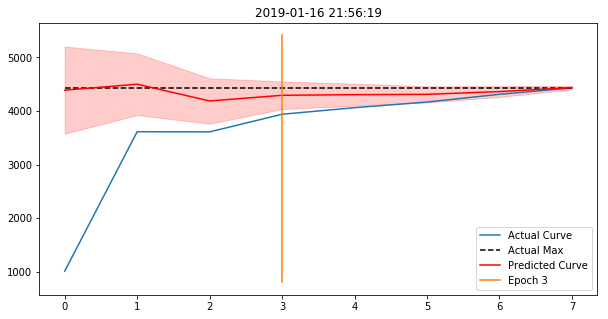

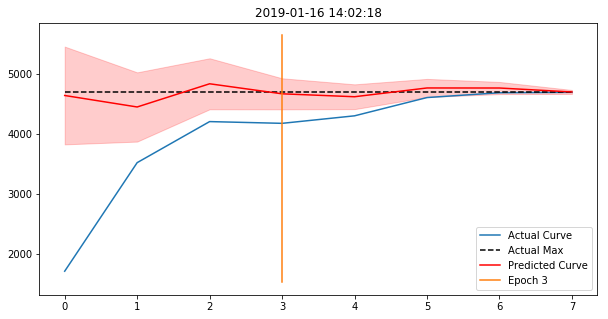

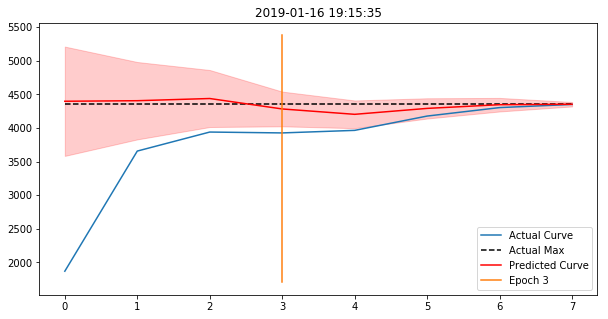

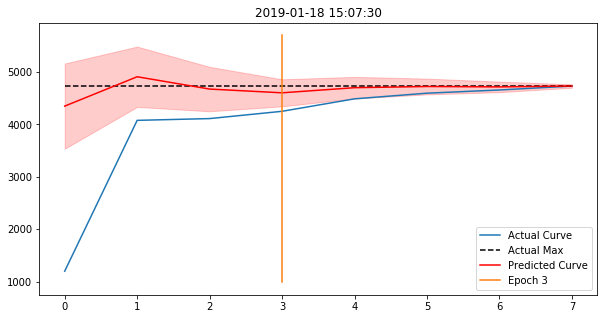

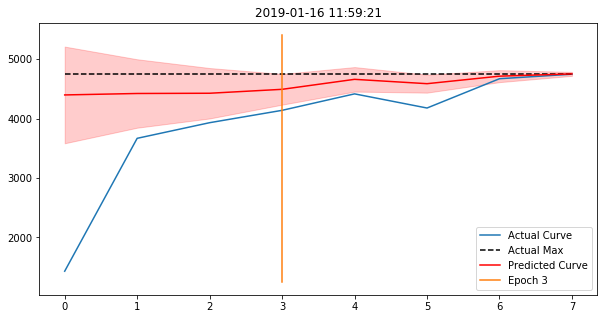

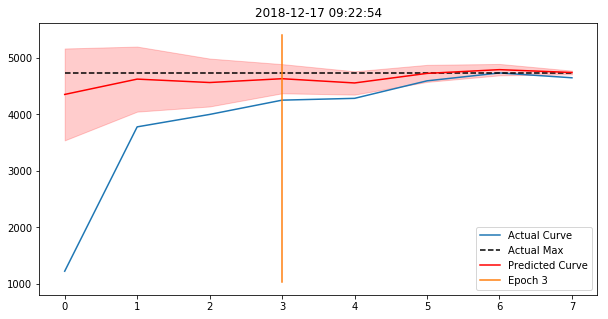

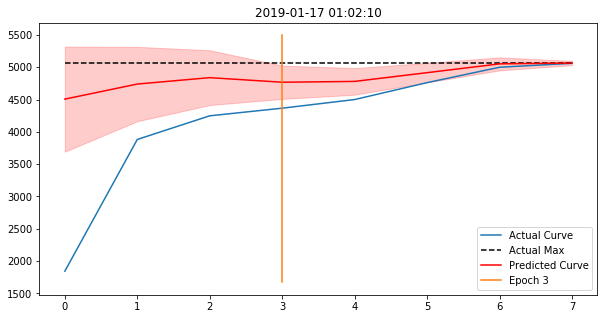

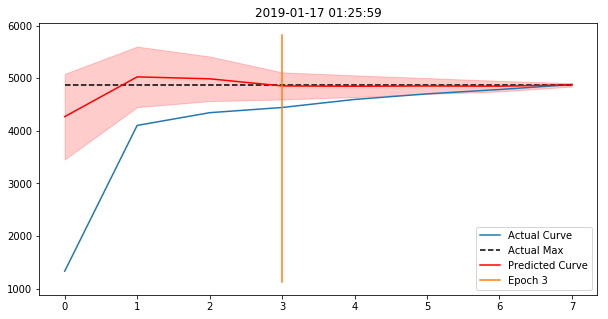

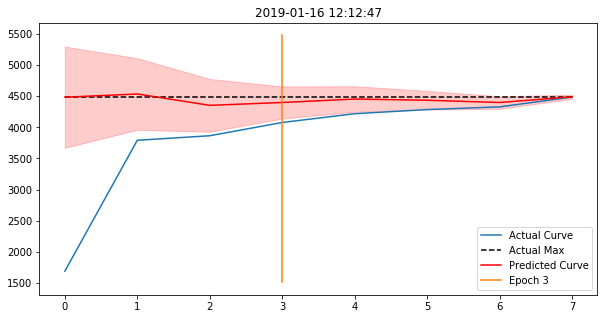

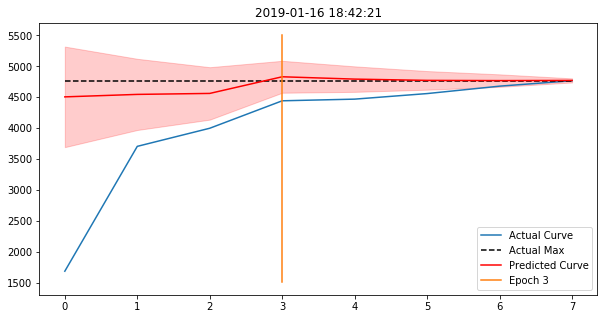

In [29]:
funcs = pkl.load(open('micro_loss_predictors.pkl',"rb"))
c95s = np.array([value['95'] for (key,value) in funcs.items()])

for idx,row in list(micro_losses.sample(10).iterrows()):
    plt.figure(figsize=(10,5))
    plt.plot(row['curve'],label='Actual Curve')
    preds = []
    for i in range(len(row['curve'])):
        selector = ['max_curve_{}'.format(j) for j in range(0,i+1)]
        selector += ['params','reductions','parallel','cells','nodes']
        X = row[selector]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    plt.fill_between(range(len(row['curve'])),preds+c95s,preds-c95s,color='red',alpha=.2)
    
    plt.plot([max(row['curve'])]*len(row['curve']),label="Actual Max",color='black',linestyle='dashed')
    plt.plot(preds,label="Predicted Curve",color='red')
    plt.plot(np.ones(100)*3,np.linspace(plt.ylim()[0],plt.ylim()[1],100),label="Epoch 3")
    plt.title(row['run_date'])
    plt.legend(loc='lower right')
    plt.show()

In [1074]:
pairs = []
matrix_id=0

no_micro,no_macro = 0,0
for matrix_df_idx,matrix_df in enumerate(matrix_dfs):
    micro_scores,macro_scores = [],[]
    micro_stats,macro_stats = [],[]
    micro,macro=False,False
    
    cell_counts = []
    for idx,row in matrix_df.iterrows():
        if len(row['cell_types'])==2 and len(row['curve'])>=7 and row['scale']==2:
            micro_scores.append(max(row['curve']))
            micro_stats.append(dict(("micro_"+k,v) for (k,v) in row.items()))
            micro=True
        elif sum(row['cell_types'])==5 and len(row['curve'])>=127:
            macro_scores.append(max(row['curve'][:128]))
            macro_stats.append(dict(("macro_"+k,v) for (k,v) in row.items()))
            macro=True
    if macro and not micro:
        no_micro +=1
    if micro and not macro:
        no_macro +=1
    if micro and macro:
        matrix_id+=1
        #micro_score = np.mean(micro_scores)
        #macro_score = np.mean(macro_scores)
        for i,micro_score in enumerate(micro_scores):
            for j,macro_score in enumerate(macro_scores):
                pair_dict = {"_micro_score":micro_score,"_macro_score":macro_score,"matrix_id":matrix_id}
                pair_dict.update(micro_stats[i])
                pair_dict.update(macro_stats[j])
                pairs.append(pair_dict)
            
pair_df = pd.DataFrame(pairs)
#general
pair_df['matrix']=pair_df['micro_cell_matrices'].apply(lambda x: x[0] if len(x)<3 else np.array(x))
pair_df['nodes']=pair_df['matrix'].apply(lambda x: len(x[0]))
pair_df['non_identities']=pair_df['matrix'].apply(lambda x: len(np.where(x>1)[0]))
pair_df['operations']=pair_df['matrix'].apply(lambda x: len(np.where(np.triu(x,k=1)>0)[0]))
pair_df['possible_ops']=pair_df['nodes'].apply(lambda x: ((x-1)*x)//2)
pair_df['density']=pair_df['operations']/pair_df['possible_ops']
pair_df['non_identity_density']=pair_df['non_identities']/pair_df['possible_ops']                                              
pair_df['concats']=pair_df['matrix'].apply(lambda x: sum(np.diag(x)))


#micro
pair_df['micro_reductions']=pair_df['micro_cell_types'].apply(sum)
pair_df['micro_delta']=pair_df['micro_curve'].apply(lambda x: max(x)-x[0])
pair_df['micro_first']=pair_df['micro_curve'].apply(lambda x: x[0])
pair_df['micro_cells']=pair_df['micro_cell_types'].apply(len)

pair_df['micro_step']=pair_df['micro_curve'].apply(lambda x: max(x)/x[0])

#macro
pair_df['macro_reductions']=pair_df['macro_cell_types'].apply(sum)
pair_df['macro_cells']=pair_df['macro_cell_types'].apply(len)
pair_df['macro_spacing']=(pair_df['macro_cells']-pair_df['macro_reductions'])/(pair_df['macro_reductions']-1)
pair_df['macro_parallel']=pair_df['macro_cell_matrices'].apply(len)
pair_df['macro_lr_max']=pair_df['macro_lr_schedule'].apply(lambda x: x['lr_max'])

pair_df.to_pickle('pair_losses.pkl')
print("Missing Micro Runs: {}, Missing Macro Runs: {}".format(no_micro,no_macro))
print("Number Test Pairs: {}".format(len(pair_df['matrix_id'].unique())))

pair_df=pair_df[(pair_df['macro_run_date'].apply(lambda x: '2019' in x))&(pair_df['micro_run_date'].apply(lambda x: '2019' in x if x else False))]
pair_df=pair_df.sort_values(by='_macro_score')
pair_df
print(len(pair_df))

Missing Micro Runs: 5, Missing Macro Runs: 591
Number Test Pairs: 51
74


In [1102]:
test_df = pair_df.copy()#[(pair_df['_macro_score']<6000)|(pair_df['_macro_score']>9000)][['_macro_score','_micro_score','macro_params','micro_params','macro_cells']]
#test_df['micro_efficiency']=test_df['_micro_score']/test_df['micro_params']
#test_df['param_scale']=test_df['macro_params']/test_df['micro_params']
#test_df['growth_coef']=test_df['micro_step']*test_df['_micro_score']
test_df=test_df.sort_values(by='_macro_score')
test_df=test_df[[test_df.columns[i] for (i,dtype) in enumerate(test_df.dtypes) if dtype!=object]]
test_df=test_df[[x for x in test_df.columns if not any([key in x for key in ['max','epoch','early','id','max','verbose']])]]
test_df=test_df[[x for x in test_df.columns if len(test_df[x].unique())!=1]]
cm = plt.cm.Greens
s = test_df.style.background_gradient(cmap=cm)
s

In [1103]:
train,test = train_test_split(test_df,test_size=.25)  

train_X,train_Y = train.drop('_macro_score',1),train['_macro_score']
test_X,test_Y = test.drop('_macro_score',1),test['_macro_score']
print(list(train_X))
train_Y,test_Y=train_Y.values/10000,test_Y.values/10000
scaler = StandardScaler()
scaler.fit(train_X)
train_X,test_X=scaler.transform(train_X),scaler.transform(test_X)

train_Y=[torch.tensor(x).float() for x in train_Y]
train_X=[torch.tensor(x).float() for x in train_X]
test_Y=[torch.tensor(x).float() for x in test_Y]
test_X=[torch.tensor(x).float() for x in test_X]

print(len(train_X),len(test_X))
print(train_X[0].shape,train_X[0].shape)

['_micro_score', 'macro_params', 'macro_scale', 'micro_params', 'nodes', 'operations', 'possible_ops', 'density', 'concats', 'micro_delta', 'micro_first', 'micro_step', 'macro_cells', 'macro_spacing', 'macro_parallel']
55 19
torch.Size([15]) torch.Size([15])


/home/campus.ncl.ac.uk/b6070424/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/campus.ncl.ac.uk/b6070424/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/home/campus.ncl.ac.uk/b6070424/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':



0.053567821992900416
P: [ 7538  7792 11401  9532 10117  7923  2119 12344  8967  5729 10786  9844 12089  9679 12185 10499  8229  4997  5354]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 3741.9520189310647
Spearman: 0.5259001148906925
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[7, 14, 12, 2, 10, 15, 4, 11, 13, 3, 8, 16, 5, 1, 0, 9, 18, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 0
Top-5 Matches: 3

0.008121279065203692
P: [ 7015  7251  9310  8547  8349  7519  1863 10543  8209  7377  9329  8787  9439  8294  7911  9817  7066  5465  7666]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1588.0838232710453
Spearman: 0.6277438767059185
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[7, 15, 12, 10, 2, 11, 3, 4, 13, 8, 14, 18, 5, 9, 1, 16, 0, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 0
Top-5 Matches: 4

0.0063269567087242025
P: [6792 7127 9288 


0.01340800454843367
P: [ 7019  7355  9130  9162  9016  6489  1873  9273 10422  7039  8682  6839  9941  8018  8868  9731  6845  5291  7544]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2175.676298330197
Spearman: 0.5057069552204322
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 7, 3, 2, 4, 14, 10, 13, 18, 1, 9, 0, 16, 11, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012737715267480541
P: [ 7058  7324  9170  9027  8995  6484  1861  9362 10387  7096  8711  6833  9761  7961  8946  9841  6885  5317  7632]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2111.7355752331455
Spearman: 0.5522390188084234
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 7, 2, 3, 4, 14, 10, 13, 18, 1, 9, 0, 16, 11, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.01292169117565017
P: [ 6979  7372  9217  


0.014596312229975027
P: [ 6957  7326  9179  9143  9057  6206  1906  8961 10793  7018  7802  6734  9740  7750  8539  9949  6715  5239  7250]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2331.5184151096832
Spearman: 0.5408254937774067
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 3, 4, 7, 14, 10, 13, 1, 18, 9, 0, 11, 16, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014309548181693955
P: [ 6991  7355  9184  9169  9128  6235  1890  8993 10822  7016  7894  6865  9707  7824  8552  9994  6861  5286  7284]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2291.997572769716
Spearman: 0.5408254937774067
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 3, 4, 7, 14, 10, 13, 1, 18, 9, 0, 11, 16, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013398440121387753
P: [ 7025  7395  9165


0.011033629237652732
P: [ 6961  7407  9124  8756  9418  6506  1968  8981 10706  6743  7782  7303  8985  7629  7948 10319  6928  5199  7445]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2019.873284231552
Spearman: 0.6251099863141454
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 4, 2, 12, 7, 3, 14, 10, 13, 18, 1, 11, 0, 16, 9, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010373865708150956
P: [ 7018  7449  9088  8649  9337  6618  1956  9014 10704  6842  7745  7489  8989  7682  7772 10405  6962  5279  7531]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1947.0564435845604
Spearman: 0.6575946344793467
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 4, 2, 7, 12, 3, 14, 10, 13, 18, 11, 1, 0, 16, 9, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.01073211597421457
P: [ 6932  7404  9090 


0.01147115911714991
P: [ 6886  7421  9160  8311  9302  6566  1908  9199 10700  6761  7839  7526  9336  7540  8325 10555  6831  5279  7478]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2043.4763353633502
Spearman: 0.5917473746850197
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 7, 2, 14, 3, 10, 13, 11, 18, 1, 0, 16, 9, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012200279155084254
P: [ 7003  7459  9140  8175  9403  6558  1907  9275 10800  6978  7932  7469  9484  7619  8663 10611  6951  5417  7710]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2065.248949388326
Spearman: 0.5908694112210953
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 7, 2, 14, 3, 10, 18, 13, 11, 1, 0, 9, 16, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012178552961490584
P: [ 7117  7515  9127 


0.012217215039874262
P: [ 6873  7545  9112  7906  9427  6744  1941  9134 10788  6880  7705  7780  9580  7696  8471 10761  6885  5226  7747]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2078.1520211600314
Spearman: 0.5645305073033645
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 7, 2, 14, 3, 11, 18, 10, 13, 1, 16, 9, 0, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011988000277920276
P: [ 6790  7530  9133  8010  9524  6738  1922  9092 10683  6813  7670  7785  9514  7687  8412 10696  6830  5195  7776]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2068.524430584433
Spearman: 0.5768219957983055
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 4, 12, 2, 7, 14, 3, 11, 18, 13, 10, 1, 16, 9, 0, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011974119663399937
P: [ 6897  7575  9109


0.009851716040621364
P: [ 6899  7570  9133  7215  9316  6810  1971  8739 10470  6868  7385  7868  9201  7769  8446 10450  6858  5043  7591]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1914.7931726629
Spearman: 0.6391574017369351
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 4, 12, 2, 7, 14, 11, 13, 18, 1, 10, 3, 0, 9, 16, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01094952035895116
P: [ 6929  7618  9158  7113  9200  6770  1843  8855 10552  6957  7518  7803  9532  7808  8620 10479  6971  4913  7627]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2009.175699742148
Spearman: 0.614574424747053
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 2, 7, 14, 13, 11, 18, 1, 10, 3, 16, 9, 0, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.009587908673606043
P: [ 6825  7583  9182  721


0.012103241360926787
P: [ 6891  7547  9170  6992  9183  6731  1933  8784 10658  6879  7221  7946  9764  7852  8555 10654  6948  5364  7592]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2107.910070236365
Spearman: 0.6084286804995825
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 2, 7, 14, 11, 13, 18, 1, 10, 3, 16, 0, 9, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011356676401766507
P: [ 6816  7540  9168  6990  9137  6650  1935  8504 10497  6794  6986  7839  9610  7812  8320 10410  6872  5278  7570]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2073.283551900636
Spearman: 0.5952592285407171
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 14, 11, 13, 18, 1, 3, 10, 16, 0, 9, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011617690792335404
P: [ 6889  7508  9178 


0.012236361191250916
P: [ 6823  7489  9088  6687  8985  6578  1923  8581 10425  6796  7009  7763 10012  7657  8108 10457  6892  5538  7560]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2157.211937386617
Spearman: 0.6233540593862966
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 14, 11, 13, 18, 1, 10, 16, 0, 9, 3, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01247937486895305
P: [ 6810  7419  9179  6548  8978  6575  1978  8598 10532  6781  6995  7779  9971  7612  8099 10523  6848  5551  7531]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2179.280943564882
Spearman: 0.6400353652008596
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 14, 11, 13, 18, 1, 10, 16, 0, 9, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012949458272080511
P: [ 6895  7509  9160  


0.013698672542791189
P: [ 6817  7472  9174  6420  8970  6572  1966  8590 10545  6766  6894  7815 10256  7587  7884 10553  6890  5548  7471]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2285.311391319151
Spearman: 0.6286218401698428
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 14, 11, 13, 1, 18, 10, 16, 0, 9, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012922412472083747
P: [ 6820  7522  9134  6574  9043  6621  1951  8549 10517  6695  6947  7965 10088  7624  7854 10617  6850  5689  7616]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2213.8666880627948
Spearman: 0.6417912921287082
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 14, 13, 18, 1, 10, 16, 0, 9, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013410042435345148
P: [ 6808  7475  9199


0.012223974188663564
P: [ 6774  7554  9136  6669  9142  6614  1944  8303 10385  6740  6925  8013  9952  7527  7325 10523  6869  5629  7653]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2161.864669255984
Spearman: 0.614574424747053
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 4, 2, 7, 11, 18, 1, 13, 14, 10, 16, 0, 9, 3, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012743426991954422
P: [ 6783  7561  9204  6490  9083  6608  1984  8234 10414  6791  6948  8043 10072  7483  7159 10543  6818  5651  7612]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2208.992895340629
Spearman: 0.6391574017369351
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 1, 13, 14, 10, 16, 9, 0, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013021862969157826
P: [ 6794  7527  9227  


0.012463276915648174
P: [ 6954  7533  9219  6476  9075  6471  1869  8365 10409  6772  6949  7909 10020  7403  7177 10417  6832  5729  7620]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2186.0235744023116
Spearman: 0.6084286804995825
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 1, 13, 14, 0, 10, 16, 9, 3, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012102027034757344
P: [ 7007  7522  9259  6483  9178  6486  1926  8353 10417  6713  6939  7879  9883  7368  7170 10370  6823  5787  7652]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2153.596478149273
Spearman: 0.6251099863141454
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 11, 18, 1, 13, 14, 0, 10, 16, 9, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011851670892072338
P: [ 6960  7497  9153


0.01216515722737648
P: [ 6908  7448  9161  6466  9014  6476  1914  8281 10232  6875  6897  7798 10128  7539  6907 10184  6856  5825  7615]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2161.589573568642
Spearman: 0.6417912921287082
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 11, 18, 13, 1, 0, 14, 10, 9, 16, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010828592927090971
P: [6924 7404 9162 6508 9083 6485 1952 8060 9919 6766 6805 7555 9787 7542 6718 9789 6802 5692 7630]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2032.0495883909375
Spearman: 0.6303777670976916
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 18, 11, 13, 1, 0, 10, 16, 9, 14, 3, 5, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01184852753613086
P: [ 6893  7419  9166  6402  9058  6483  1


0.011861277699489093
P: [ 6991  7321  9173  6222  9028  6482  1871  8424 10232  6900  6803  7673 10071  7560  6982  9940  6861  5761  7714]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2134.568618180186
Spearman: 0.5812118131179274
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 2, 4, 7, 18, 11, 13, 1, 0, 14, 9, 16, 10, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012834021792274908
P: [ 6941  7273  9167  6154  9028  6476  1870  8530 10283  6949  6847  7761 10339  7604  7030 10048  6840  5778  7710]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2220.2520765752797
Spearman: 0.5873575573653979
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 8, 15, 2, 4, 7, 11, 18, 13, 1, 14, 9, 0, 10, 16, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012195853271374577
P: [ 6895  7273  9080


0.011654935717017093
P: [ 6945  7346  9184  6208  9113  6498  1909  8731 10029  6998  6741  7851 10036  7656  6859 10065  6909  5884  7873]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2115.0866844901366
Spearman: 0.570676251550835
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 1, 9, 0, 16, 14, 10, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011076421937966523
P: [6927 7247 9076 6114 9044 6483 1944 8562 9762 6956 6721 7648 9943 7612 6638 9735 6843 5667 7791]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2056.331858003577
Spearman: 0.570676251550835
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 8, 15, 2, 4, 7, 18, 11, 13, 1, 9, 0, 16, 10, 14, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011575831125020685
P: [ 6993  7303  9202  6172  8983  6471  1


0.011021369083161852
P: [ 6940  7283  9231  6198  9078  6462  1846  8902 10038  6986  6914  7864  9890  7517  6550  9988  6856  5809  7693]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2057.4848389385643
Spearman: 0.643547219056557
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 11, 18, 13, 1, 9, 0, 10, 16, 14, 5, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010738756325730193
P: [ 6974  7334  9199  6221  9145  6507  1961  8847  9998  6948  6868  7888  9787  7656  6485 10013  6942  5890  7850]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2030.5337596567604
Spearman: 0.6172083151388261
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 1, 0, 9, 16, 10, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010432843312341183
P: [6888 7203 9097 62


0.011872018005557325
P: [ 6883  7404  9194  6247  9169  6471  1918  8840 10261  6945  6773  7930  9919  7537  6300  9905  6979  5862  7612]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2135.491788350901
Spearman: 0.5943812650767927
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 2, 4, 7, 11, 18, 13, 1, 16, 9, 0, 10, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011073527779675069
P: [6887 7382 9131 6220 9210 6487 1902 8736 9981 6958 6801 7804 9793 7484 6195 9686 6991 5692 7642]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2058.0678090398515
Spearman: 0.5794558861900786
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 11, 18, 13, 1, 16, 9, 0, 10, 5, 3, 14, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01080968885526165
P: [ 6930  7349  9112  6198  9195  6469  


0.010151765757702953
P: [6964 7415 9173 6162 9257 6511 1942 8863 9753 6984 7055 7910 9743 7495 6216 9720 7033 5835 7745]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1973.9870208645818
Spearman: 0.6400353652008596
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 11, 18, 13, 1, 10, 16, 9, 0, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.009909011455850927
P: [6936 7316 9131 6174 9181 6477 1875 8691 9847 6946 6981 7676 9671 7454 6313 9414 6883 5645 7670]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1940.147232983982
Spearman: 0.6514488902318762
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 11, 18, 13, 1, 10, 9, 0, 16, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01017333089606983
P: [ 6982  7425  9191  6242  9252  6502  1893  8887 10054  6


0.010709568209270066
P: [ 6923  7347  9226  6121  9137  6482  1924  8940  9721  6961  7111  7932 10028  7502  6413  9772  6943  5867  7604]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2028.1811325558183
Spearman: 0.6251099863141454
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 4, 7, 11, 18, 13, 1, 10, 9, 16, 0, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01032469005913658
P: [6898 7287 9125 6137 9098 6473 1874 8761 9512 6955 7030 7769 9953 7501 6333 9503 6927 5710 7549]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1982.034190860393
Spearman: 0.6303777670976916
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 8, 15, 2, 4, 7, 11, 18, 13, 1, 10, 9, 16, 0, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01063430232838713
P: [ 6940  7357  9234  6150  9105  6482  1


0.010209095669456235
P: [6910 7344 9139 6223 9110 6470 1909 8874 9423 6936 7099 7871 9960 7551 6239 9603 6946 5882 7597]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1976.3580100074923
Spearman: 0.6172083151388261
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 4, 7, 11, 18, 13, 1, 10, 16, 9, 0, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010770069984890765
P: [ 6915  7401  9231  6187  9138  6502  1997  9046  9539  6974  7169  8030 10034  7536  6194  9888  6994  6087  7644]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2033.699737759184
Spearman: 0.6172083151388261
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 4, 7, 11, 18, 13, 1, 10, 16, 9, 0, 5, 14, 3, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010248994476882737
P: [6916 7305 9127 6190 9060 6470 1896 8


0.010234015322334986
P: [6859 7325 9114 6272 9047 6460 1894 8896 9359 6962 7061 7861 9931 7520 6136 9624 6923 5971 7619]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1977.328029169849
Spearman: 0.6189642420666749
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 4, 7, 11, 18, 13, 1, 10, 9, 16, 0, 5, 3, 14, 17, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01017516580608763
P: [6897 7407 9162 6307 9125 6483 1944 8977 9291 6909 7102 7987 9843 7558 6028 9786 6972 6126 7725]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1976.0377777002684
Spearman: 0.6005270093242633
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 4, 7, 11, 18, 13, 1, 10, 16, 9, 0, 5, 3, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010259238030782495
P: [6953 7349 9229 6295 9035 6464 1889 9035 9604 6933 7177 7


0.009703938434105646
P: [6943 7306 9126 6455 9032 6453 1875 8988 9371 6907 7178 7856 9814 7596 6016 9659 6914 6115 7652]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1927.8278357747122
Spearman: 0.5882355208293223
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 4, 7, 11, 18, 13, 1, 10, 0, 16, 9, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01015786640250314
P: [6950 7383 9230 6493 9108 6495 1959 9174 9517 6933 7272 8023 9921 7640 6092 9901 6996 6304 7782]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1973.1106446151541
Spearman: 0.599649045860339
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 7, 4, 11, 18, 13, 1, 10, 16, 0, 9, 5, 3, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.010009214528293486
P: [6897 7305 9114 6517 9013 6458 1870 8949 9311 6925 7127 7


0.010058402464341941
P: [6960 7335 9196 6652 9074 6494 1962 9077 9324 6905 7242 7925 9848 7591 5803 9783 6975 6214 7761]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1965.6578897016286
Spearman: 0.5882355208293223
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 2, 7, 4, 11, 18, 13, 1, 10, 16, 0, 9, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.009982672759178968
P: [6999 7275 9201 6550 9026 6460 1866 9220 9555 6941 7364 7989 9917 7660 6001 9853 6928 6223 7629]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1957.6231800223104
Spearman: 0.6180862786027504
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 7, 2, 4, 11, 13, 18, 10, 1, 0, 9, 16, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.010318445663433283
P: [6901 7364 9192 6617 9035 6477 1968 9163 9367 6923 7248


0.010155362449088563
P: [6967 7364 9199 6711 9061 6501 1971 9195 9351 6940 7326 7985 9848 7630 5754 9905 6989 6351 7797]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1974.1407631232712
Spearman: 0.6093066439635069
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 7, 4, 11, 18, 13, 1, 10, 16, 0, 9, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.00993532875169254
P: [7020 7307 9216 6654 9066 6465 1862 9203 9499 6927 7363 7948 9821 7691 5801 9834 6923 6312 7695]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1953.1160369662748
Spearman: 0.6391574017369351
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 7, 4, 11, 18, 13, 10, 1, 0, 9, 16, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.009932317132314426
P: [6941 7274 9144 6779 8998 6474 1893 9055 9349 6928 7284 


0.010062071022745337
P: [6937 7351 9163 6906 9106 6485 1916 9152 9309 6917 7325 7886 9785 7606 5647 9801 6960 6310 7855]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1965.7170176278398
Spearman: 0.6093066439635069
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 7, 4, 11, 18, 13, 1, 10, 16, 0, 9, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.010209963111887382
P: [6938 7299 9145 6898 9043 6455 1799 9181 9527 6984 7330 7876 9858 7624 5667 9739 6888 6256 7749]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1980.2319522280543
Spearman: 0.6172083151388261
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 15, 8, 7, 2, 4, 11, 18, 13, 10, 1, 9, 0, 3, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.01055518786005163
P: [6913 7352 9205 6919 9056 6477 1883 9315 9533 6961 7385 


0.009977018042293725
P: [6918 7352 9191 6949 8929 6480 1972 9149 9550 6934 7214 7954 9693 7602 5697 9911 6988 6298 7779]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1957.5283583651806
Spearman: 0.6022829362521119
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 7, 4, 11, 18, 13, 1, 10, 16, 3, 9, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.010125857153692968
P: [ 6974  7342  9231  6892  8928  6485  1967  9246  9627  6950  7262  8053  9679  7642  5680 10047  7005  6381  7767]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1969.8862601528692
Spearman: 0.6040388631799608
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 7, 2, 4, 11, 18, 13, 1, 10, 16, 0, 9, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.010363641509597624
P: [6949 7284 9191 6927 8909 6462 1864 


0.010029889472685969
P: [ 7028  7381  9236  6997  9057  6513  1977  9134  9511  7006  7324  8015  9577  7656  5496 10065  7026  6363  7908]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1960.0920744024197
Spearman: 0.6128184978192044
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 7, 4, 11, 18, 13, 1, 10, 0, 16, 9, 3, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.010007152791858013
P: [ 6997  7380  9211  7002  9041  6500  1957  9095  9422  6989  7304  7966  9552  7629  5426 10016  7014  6296  7876]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1959.9838258612426
Spearman: 0.5978931189324901
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 7, 4, 11, 18, 13, 1, 10, 16, 3, 0, 9, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 4

0.009995480113359104
P: [6972 7372 9211 6


0.010397980224393982
P: [6961 7365 9177 7076 9096 6489 1946 8927 9174 7003 7259 7838 9455 7565 5075 9899 6958 6131 7835]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1995.5414456273816
Spearman: 0.61194053435528
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 8, 4, 7, 11, 18, 13, 1, 10, 3, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010503371102291376
P: [ 6973  7376  9208  7079  9088  6493  1958  8999  9226  6997  7282  7930  9477  7589  5111 10031  6978  6237  7818]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2008.099755597847
Spearman: 0.6066727535717338
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 11, 18, 13, 1, 10, 3, 9, 16, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010749318206523495
P: [ 6984  7372  9240  7112  9076  6493  1


0.010440566099317183
P: [6996 7302 9154 7229 9103 6467 1919 8920 9343 7018 7226 7778 9334 7544 4976 9857 6893 6068 7719]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 1997.1627646208035
Spearman: 0.614574424747053
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 1, 3, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010668116277157113
P: [ 7040  7345  9239  7246  9162  6482  1894  9135  9535  7031  7345  7930  9444  7649  5098 10102  6946  6194  7803]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2023.9730318657084
Spearman: 0.641633790467527
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 1, 10, 3, 0, 9, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01094233555908144
P: [ 6972  7409  9185  7286  9124  6500  1


0.010679686202611774
P: [7010 7326 9185 7263 9125 6465 1894 8979 9372 7031 7252 7866 9149 7542 4745 9947 6913 6113 7730]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2020.5547559737374
Spearman: 0.6426692555926327
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 2, 12, 4, 7, 11, 18, 13, 1, 3, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 2
Top-5 Matches: 3

0.010820669976792518
P: [6988 7304 9154 7271 9099 6464 1901 8944 9320 7042 7256 7819 9212 7522 4708 9884 6899 6069 7726]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2031.1388416558582
Spearman: 0.614574424747053
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 1, 3, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.010859498192937616
P: [6956 7305 9146 7303 9066 6470 1928 8863 9252 7029 7236 


0.011399063615088105
P: [6976 7390 9172 7275 9203 6499 1960 8917 9212 6961 7279 7843 9251 7504 4602 9979 6950 6044 7883]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2087.7026688609117
Spearman: 0.5935033016128684
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 4, 2, 7, 18, 11, 13, 1, 10, 3, 0, 9, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011410826739189648
P: [6999 7310 9154 7273 9152 6470 1899 8946 9401 7054 7274 7799 9347 7510 4677 9957 6897 6043 7762]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2088.636613351033
Spearman: 0.636523511345162
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 1, 10, 3, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.0115383700604549
P: [ 7008  7388  9238  7323  9174  6498  1941  9101  9601  703


0.011956609987324004
P: [6960 7271 9121 7327 9119 6464 1876 8859 9299 7087 7239 7740 9298 7440 4414 9820 6873 5934 7740]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2128.782577242753
Spearman: 0.6095740596638791
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 3, 1, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012129873305974271
P: [ 7003  7301  9174  7258  9190  6452  1843  9034  9473  7068  7283  7885  9312  7483  4486 10078  6877  6087  7739]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2154.5490229057573
Spearman: 0.6277438767059185
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 4, 2, 7, 11, 18, 13, 1, 10, 3, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011434760217717235
P: [ 7015  7390  9227  7322  9178  6513 


0.011986149620784809
P: [ 7025  7284  9186  7319  9214  6467  1863  9001  9566  7084  7275  7874  9396  7577  4591 10019  6920  6203  7793]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2144.354460222447
Spearman: 0.6022829362521119
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 4, 2, 7, 11, 18, 13, 3, 1, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012763682885639881
P: [6978 7269 9110 7381 9201 6467 1852 8926 9352 7125 7231 7821 9369 7476 4285 9937 6915 6128 7809]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2207.7673856613674
Spearman: 0.5759440323343812
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 4, 2, 7, 11, 18, 13, 3, 1, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.011737613041657968
P: [6998 7302 9153 7318 9227 6473 1884 8


0.01227389842257615
P: [6963 7339 9164 7385 9217 6500 1923 8846 9297 7036 7247 7778 9293 7498 4345 9869 6956 6126 7917]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2164.9532739755623
Spearman: 0.5987710823964145
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 4, 2, 7, 18, 11, 13, 3, 1, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012182470879021199
P: [6965 7265 9129 7341 9143 6464 1903 8811 9413 7051 7181 7742 9348 7514 4427 9824 6903 6123 7736]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2153.322545090111
Spearman: 0.6022829362521119
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 4, 2, 7, 11, 18, 13, 3, 1, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.012525141382339873
P: [6926 7247 9090 7374 9112 6457 1886 8801 9350 7060 7157 7


0.013318533908061096
P: [ 6962  7324  9191  7418  9143  6503  1968  8967  9349  7069  7209  7933  9393  7477  4203 10108  7026  6231  7856]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2259.657707748757
Spearman: 0.5812118131179274
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 11, 18, 13, 3, 1, 10, 9, 16, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.0128907008133147
P: [ 6979  7311  9226  7392  9145  6494  1942  9033  9609  7086  7222  7958  9481  7567  4445 10134  6999  6259  7853]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2225.054754744494
Spearman: 0.6075507170356581
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 3, 1, 10, 9, 16, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013093787318107269
P: [ 7007  7267  9219  7


0.013133222831464465
P: [ 6959  7314  9186  7384  9108  6498  1966  8887  9433  7073  7142  7915  9431  7515  4296 10053  6984  6236  7912]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2243.624363920538
Spearman: 0.6075507170356581
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 3, 1, 10, 9, 16, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013823844198046381
P: [ 6994  7282  9193  7384  9110  6490  1931  8996  9511  7135  7180  7958  9478  7532  4154 10148  6988  6281  7879]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2303.074251693921
Spearman: 0.6110625708913555
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 3, 1, 10, 9, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013443866086259061
P: [ 6999  7257  9197 


0.013466430088603949
P: [6999 7221 9164 7293 9070 6457 1866 8765 9488 7144 7006 7886 9417 7524 4221 9985 6895 6288 7750]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2266.1602439574026
Spearman: 0.5970151554685659
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 3, 1, 9, 10, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01347188216102555
P: [6904 7266 9084 7315 9038 6471 1890 8613 9152 7059 6999 7751 9315 7419 4063 9770 6869 6097 7823]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2248.0171592665365
Spearman: 0.5671643976951375
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 3, 1, 9, 10, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013677568999235902
P: [ 6971  7300  9187  7349  9079  6491  1945  8870  9504  


0.014052072545765489
P: [ 6976  7244  9226  7368  9030  6487  1942  8774  9379  7171  7058  7998  9502  7476  4120 10102  6982  6402  7800]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2319.665270513049
Spearman: 0.5671643976951375
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 11, 18, 13, 3, 1, 9, 10, 16, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013918492732285048
P: [6954 7258 9134 7347 9038 6487 1958 8596 9126 7121 7023 7849 9374 7408 4003 9908 6972 6264 7851]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2296.3891711796928
Spearman: 0.5654084707672888
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 8, 4, 7, 18, 11, 13, 3, 1, 9, 10, 16, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013705209643136951
P: [6939 7192 9099 7285 9006 6452 1873 8


0.013432417945529395
P: [6999 7272 9162 7264 9128 6501 1967 8575 9250 7154 7058 7859 9355 7465 4154 9992 6966 6292 7956]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2262.8103963090502
Spearman: 0.570676251550835
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 1, 3, 9, 10, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01377758204738424
P: [6924 7251 9128 7208 9101 6479 1920 8404 8922 7074 6964 7734 9197 7373 3938 9766 6900 6146 7850]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2263.172069380335
Spearman: 0.5654084707672888
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 4, 8, 7, 18, 11, 13, 1, 3, 9, 10, 0, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013975556588680374
P: [6933 7189 9098 7173 9032 6448 1872 8329 8950 7094 6884 76


0.014002733498943454
P: [ 6919  7270  9201  7318  9085  6508  1976  8519  9089  7148  6990  7941  9363  7443  4045 10045  7013  6425  7819]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2308.5314666698796
Spearman: 0.5469712380248772
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 8, 4, 7, 11, 18, 13, 3, 1, 9, 16, 10, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014176203509697715
P: [ 6983  7293  9196  7329  9102  6520  1971  8588  9189  7175  7025  7997  9370  7448  4032 10152  7045  6484  7884]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2328.4779936941654
Spearman: 0.5469712380248772
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 8, 4, 7, 11, 18, 13, 3, 1, 9, 16, 10, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.0140157351312442
P: [ 7000  7285  9221 


0.014758530924513923
P: [6875 7190 9096 7230 9005 6462 1916 8314 8945 7108 6874 7751 9285 7322 3799 9797 6928 6278 7606]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2335.5511130446966
Spearman: 0.5215102975710707
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 4, 8, 7, 11, 18, 13, 3, 1, 9, 16, 0, 10, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014291189521468607
P: [6894 7237 9138 7269 9049 6485 1944 8387 9067 7120 6929 7820 9366 7377 3976 9919 6960 6346 7740]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2318.8786634885128
Spearman: 0.5469712380248772
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 8, 4, 7, 11, 18, 13, 3, 1, 9, 16, 10, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.013632208827929341
P: [ 6943  7302  9212  7301  9115  6500  1956  8505  9345 


0.014563562062520711
P: [ 6910  7258  9184  7268  9043  6490  1949  8417  9170  7157  6964  7870  9439  7349  3996 10053  6979  6450  7717]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2349.847439914821
Spearman: 0.5469712380248772
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 2, 8, 4, 7, 11, 18, 13, 3, 1, 9, 16, 10, 0, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014579865860041225
P: [ 6960  7221  9208  7259  9050  6465  1898  8451  9379  7189  6939  7892  9461  7421  4037 10062  6916  6499  7648]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2354.167814270313
Spearman: 0.5364356764577849
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 11, 18, 13, 3, 1, 9, 0, 10, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014848726782618445
P: [6920 7185 9154 720


0.014150795744693087
P: [6901 7208 9118 7204 9089 6467 1911 8187 9203 7088 6872 7667 9405 7349 4090 9720 6863 6312 7742]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2296.989890806331
Spearman: 0.5522390188084234
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 1, 3, 9, 0, 10, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015153094896259302
P: [ 6962  7236  9212  7292  9055  6471  1911  8483  9501  7211  6977  7906  9664  7418  4102 10187  6944  6597  7686]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2407.9258270867163
Spearman: 0.5548729092001965
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 11, 18, 13, 3, 1, 9, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014133659330690008
P: [6960 7183 9133 7217 9059 6442 1843 8


0.014440515393863805
P: [6992 7200 9169 7216 9128 6452 1856 8229 9494 7186 6874 7727 9438 7423 4103 9850 6874 6496 7705]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2336.7260054554417
Spearman: 0.5520422139751413
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 11, 18, 13, 3, 1, 9, 0, 10, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014249292841525044
P: [6969 7236 9197 7233 9115 6491 1963 8213 9390 7055 6925 7733 9342 7337 4063 9873 6920 6464 7805]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2319.6628345293957
Spearman: 0.5785779227261543
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 18, 11, 13, 1, 3, 9, 0, 10, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01434434363248951
P: [6914 7193 9147 7251 9043 6444 1868 8210 9530 7140 6803 


0.014978076585640864
P: [6958 7190 9125 7227 9114 6455 1842 8117 9422 7176 6820 7630 9443 7388 3962 9703 6874 6440 7721]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2368.4688565879746
Spearman: 0.5267780783546169
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 3, 1, 9, 0, 16, 10, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015435445092838276
P: [ 6963  7258  9205  7321  9115  6505  1959  8344  9525  7190  6949  7875  9618  7403  4014 10100  7000  6670  7862]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2430.566259794406
Spearman: 0.5109747360039784
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 11, 18, 13, 3, 1, 9, 16, 0, 10, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014752928179261385
P: [6922 7194 9077 7258 9105 6468 1875 8


0.015345202230252509
P: [7030 7240 9217 7271 9203 6480 1881 8295 9740 7160 6954 7761 9539 7435 4006 9971 6932 6676 7864]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2422.0832453629964
Spearman: 0.5592627265198182
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 18, 11, 13, 3, 1, 9, 0, 10, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01477366954340572
P: [6858 7213 9089 7266 9041 6468 1902 8054 9350 7110 6783 7631 9417 7361 3998 9617 6908 6444 7666]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2344.2749761962536
Spearman: 0.5232662244989195
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 3, 1, 9, 16, 0, 10, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015454159908651826
P: [7015 7250 9223 7295 9235 6487 1886 8320 9677 7187 6966 


0.015303764998694342
P: [6995 7206 9231 7301 9145 6473 1914 8254 9829 7135 6947 7732 9607 7413 4058 9850 6920 6678 7755]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2417.2397738177146
Spearman: 0.5592627265198182
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 8, 12, 2, 4, 7, 18, 11, 13, 3, 1, 9, 0, 10, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01510414894652824
P: [6912 7265 9174 7331 9174 6508 1951 8195 9492 7130 6914 7779 9583 7440 4022 9780 6989 6672 7889]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2399.1321643260094
Spearman: 0.5217391807497755
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 3, 1, 9, 16, 10, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015192989560642002
P: [6912 7174 9098 7250 9050 6440 1844 7998 9501 7089 6792 


0.015253787495423336
P: [6888 7251 9153 7309 9085 6485 1957 8107 9452 7074 6875 7710 9544 7391 3938 9656 6962 6622 7741]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2399.8039813358623
Spearman: 0.507462882148281
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[15, 12, 8, 2, 4, 7, 18, 11, 13, 3, 1, 9, 16, 0, 10, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015274039326725056
P: [6961 7208 9148 7309 9200 6477 1870 8030 9629 7120 6895 7520 9352 7334 3810 9397 6878 6471 7815]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2389.6188651095667
Spearman: 0.5715542150147593
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 2, 7, 18, 11, 13, 3, 1, 9, 0, 10, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015274062873638621
P: [6940 7178 9157 7376 9155 6473 1857 8201 9776 7224 6910 


0.015172930350110235
P: [6883 7209 9098 7356 9141 6480 1865 8039 9640 7189 6905 7565 9611 7420 3995 9394 6913 6547 7764]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2390.629230185934
Spearman: 0.5276560418185412
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 18, 11, 13, 3, 1, 9, 16, 10, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.014831443365198394
P: [6862 7239 9104 7311 9180 6481 1878 8014 9453 7149 6870 7617 9550 7446 4037 9408 6938 6568 7789]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2361.235420709527
Spearman: 0.5013171379008105
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[12, 8, 15, 4, 2, 7, 18, 11, 13, 3, 1, 9, 16, 10, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015110221569102578
P: [6909 7173 9137 7288 9070 6433 1849 7979 9720 7098 6809 7


0.015686892298257243
P: [6985 7243 9180 7325 9275 6502 1913 7990 9592 7065 6950 7640 9343 7310 3751 9556 6951 6732 7869]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2433.5374601903263
Spearman: 0.5188764071792976
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 4, 2, 7, 18, 11, 3, 13, 1, 9, 0, 16, 10, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015704514399359187
P: [6882 7208 9130 7368 9191 6490 1915 8059 9641 7196 6965 7593 9566 7402 3793 9396 6921 6587 7807]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2434.227078309131
Spearman: 0.5496051284166503
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 18, 11, 13, 3, 1, 9, 10, 16, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015808053400914297
P: [6840 7200 9101 7282 9097 6461 1909 7925 9322 7055 6840 


0.015206880482441863
P: [6943 7151 9134 7302 9187 6458 1866 7845 9772 7122 6891 7402 9326 7316 3879 9173 6839 6457 7690]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2371.428062447135
Spearman: 0.548727164952726
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 4, 15, 2, 7, 18, 11, 13, 3, 1, 9, 0, 10, 16, 5, 17, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.016086935303034903
P: [ 6979  7194  9237  7360  9178  6452  1859  8058 10122  7180  6993  7545  9610  7355  3923  9553  6882  6702  7644]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2472.741645911239
Spearman: 0.5469712380248772
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 2, 4, 7, 18, 11, 3, 13, 1, 9, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.016182246004399003
P: [6982 7197 9241 7344 9245 6469 1930 811


0.016552678763990736
P: [ 6916  7118  9200  7423  9057  6447  1887  7936 10070  7205  7030  7593  9632  7349  3830  9618  6880  6863  7549]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2506.3368292492073
Spearman: 0.5548729092001965
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 2, 4, 7, 11, 18, 3, 13, 9, 1, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.016676767073764302
P: [6864 7215 9160 7413 9130 6470 1935 7998 9756 7082 7037 7648 9517 7294 3627 9657 6922 6802 7703]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2511.444707811514
Spearman: 0.5645305073033645
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 15, 12, 2, 4, 7, 18, 11, 3, 13, 1, 9, 10, 16, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.0165465090256978
P: [6855 7164 9129 7411 9061 6444 1850 785


0.015921290680508765
P: [ 6931  7120  9181  7439  9175  6453  1867  7961 10028  7254  6981  7538  9741  7407  4077  9512  6899  6786  7607]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2461.390075246032
Spearman: 0.551361055344499
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 2, 4, 7, 18, 11, 3, 13, 9, 1, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01656851100559128
P: [6872 7155 9103 7471 9132 6466 1889 7912 9839 7303 7033 7454 9713 7339 3776 9400 6963 6668 7613]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2501.274321636829
Spearman: 0.5259001148906925
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 18, 3, 11, 13, 9, 1, 10, 16, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015905564914431267
P: [6847 7185 9062 7470 9193 6470 1874 7859


0.01621146032986369
P: [ 7025  7236  9254  7551  9327  6507  1903  8053 10234  7280  7106  7553  9827  7518  4089  9537  6979  6819  7906]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2494.649966357645
Spearman: 0.5425814207052554
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 18, 11, 3, 13, 9, 1, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015494399005565117
P: [ 6927  7130  9187  7522  9193  6479  1890  7962 10133  7251  6986  7521  9877  7511  4306  9367  6917  6736  7608]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2432.723541083497
Spearman: 0.52941196874639
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 18, 3, 11, 13, 9, 1, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.016333414979989788
P: [6898 7245 9180 7534 9


0.0164095710221629
P: [6910 7245 9175 7573 9184 6501 1950 7935 9948 7310 7025 7547 9826 7402 3951 9452 7065 6726 7746]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2503.521981027325
Spearman: 0.5039510282925834
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 4, 2, 7, 18, 3, 11, 13, 9, 1, 16, 10, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015482462040582748
P: [6849 7246 9106 7510 9254 6479 1897 7784 9845 7293 6924 7415 9686 7423 4126 9179 6957 6570 7736]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2418.9700026736386
Spearman: 0.5039510282925834
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 4, 15, 2, 7, 18, 3, 13, 11, 9, 1, 16, 10, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.015833984999325798
P: [ 6887  7188  9151  7540  9191  6460  1869  7788 10048  73


0.016128444431462628
P: [6831 7210 9099 7592 9153 6470 1878 7662 9870 7356 6900 7331 9574 7360 3918 9084 6947 6558 7612]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2457.0228143111385
Spearman: 0.5057069552204322
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 4, 2, 15, 7, 18, 3, 13, 9, 11, 1, 16, 10, 0, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01731064196412945
P: [ 6970  7226  9255  7598  9201  6469  1924  7836 10235  7293  7017  7416  9686  7332  3796  9502  6952  6765  7682]
R: [7077 7077 9114 6955 8269 7926 1897 8833 8931 7402 8881 8176 6858 8212 7354 8669 6955 6028 7653]
C95: 2569.417397616317
Spearman: 0.5381916033856337
[2, 8, 10, 7, 15, 4, 13, 11, 5, 18, 9, 14, 0, 1, 3, 16, 12, 17, 6]
[8, 12, 15, 2, 4, 7, 18, 3, 11, 13, 9, 1, 10, 0, 16, 17, 5, 14, 6]
Top-1 Matches: 0
Top-3 Matches: 1
Top-5 Matches: 3

0.01616688468929383
P: [ 6970  7184  9232  7586  9280  6478  1

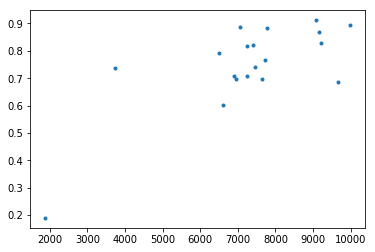

In [1106]:
class Regressor(nn.Module):
    def __init__(self,size):
        super().__init__()
        self.fc1 = nn.Linear(train_X[0].shape[0], size)
        self.fc2 = nn.Linear(size, size)
        self.fc3 = nn.Linear(size, 1)
        
    def forward(self,x):
        x =  F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x =  self.fc3(x)
        return x#F.sigmoid(x)

criterion = nn.MSELoss()
net = Regressor(128)
optimizer = optim.Adam(net.parameters())#, momentum=.9, weight_decay=3e-4)

for epoch in range(100000):
    net.train()
    
    for i,val in enumerate(train_X):
        optimizer.zero_grad()
        output = net(val)
        loss = criterion(output,train_Y[i])
        loss.backward()
        optimizer.step()
    net.eval()
    losses,preds = [],[]
    for i,val in enumerate(test_X):
        output = net(val)
        loss = criterion(output,test_Y[i]).item()
        losses.append(loss)
        preds.append(int(output.item()*1e4))
        
    if not epoch%100:
        print()
        print(np.mean(losses))
        preds = np.array(preds)
        reals = np.array([int(x.item()*1e4) for x in test_Y])
        print("P:",preds)
        print("R:",reals)
        print("C95:",np.std(preds-reals)*1.96)
        print("Spearman:",spearmanr(preds,test_Y)[0])
        top_tests = top_n(test_Y) 
        top_preds = top_n(preds)
        print([top_test[0] for top_test in top_tests])
        print([top_pred[0] for top_pred in top_preds])
        print("Top-1 Matches:",len([1 for test_val in top_tests[:1] if test_val[0] in [pred[0] for pred in top_preds[:1]]]))
        print("Top-3 Matches:",len([1 for test_val in top_tests[:3] if test_val[0] in [pred[0] for pred in top_preds[:3]]]))
        print("Top-5 Matches:",len([1 for test_val in top_tests[:5] if test_val[0] in [pred[0] for pred in top_preds[:5]]]))
plt.plot(preds,test_Y,".")

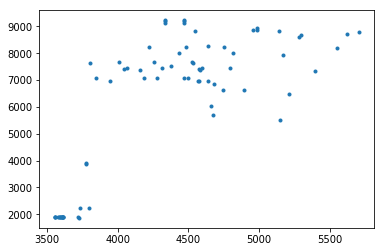

In [802]:
plt.plot(pair_df['_micro_score'],pair_df['_macro_score'],".")